In [1]:
#Import Dependencies
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import time
import traceback
import copy
import pickle
import collections

import warnings
warnings.filterwarnings("ignore")

In [2]:
path="emph_csv/" #Path with emphysema files from REDCap, one for each degree

In [3]:
#Read excel files with data
mod=pd.read_excel(os.getcwd()+'/emphysema_exp_files'+"\\moderate_manual.xlsx")
conf=pd.read_excel(os.getcwd()+'/emphysema_exp_files'+"\\moderate_manual.xlsx")
adv=pd.read_excel(os.getcwd()+'/emphysema_exp_files'+"\\advanced_manual.xlsx")
noemph=pd.read_excel(os.getcwd()+'/emphysema_exp_files'+"\\noemphysema_manual.xlsx")

In [4]:
#Needed for FN extraction
path_noemph=os.getcwd()+'/no_emphysema_reviewed'
path_emph=os.getcwd()+'/emphysema_reviewed'

In [5]:
start=time.time()

In [6]:
emphysema_data=pd.DataFrame() #Create empty dataframe

In [2]:
#Combine all dataframes with the different degrees of emphysema

total_pat=0 #count number of participants

for file in os.listdir(path): #loop over dataframes
    print(file.split('-')[1].split("_")[0]) #print emphysema degree
    dataframe=file.split('-')[1].split("_")[0] #Use degree of emphysema as a name for each corresponding dataframe
    exec(dataframe+'=pd.read_csv(os.getcwd()+"/"+path+file)') #read each dataframe
    exec(dataframe+"['Emphysema']=str(dataframe)") #Add column with emphysema degree
    emphysema_data=emphysema_data.append(eval(dataframe)) #Combine each emphysema dataframe to another dataframe
    total_pat=total_pat+len(eval(dataframe)) #Add number of participants of that degree to the total number of participants
    print(len(np.unique(eval(dataframe+"['participant_id']")))) #print num of unique participants of that degree of emphysema

    assert(total_pat==len(emphysema_data)) #Confirm that everything worked

In [1]:
print("Number of unique participants is {}".format(len(np.unique(emphysema_data['participant_id']))))
print("We have in total {} participants".format(len(emphysema_data)))

In [9]:
#Emphysema types ordered by severity - Taken from np.unique(emphysema_data['Emphysema'])
severity=["AdvancedCentrEmphyNo","ConfluentCentrEmphyN","ModerateCentrEmphyNo","MidCentrEmphyNodules",
          "TraceCentrEmphyNodul","NoCentrEmphyNodules"]

In [10]:
severity_nums=[5,4,3,2,1,0] #create integers from the most severe to the least one

In [11]:
severity_dict={} #create a dict with severity name and corresponding integer
for index,val in enumerate(severity):
    severity_dict[val]=severity_nums[index]
severity_dict

{'AdvancedCentrEmphyNo': 5,
 'ConfluentCentrEmphyN': 4,
 'ModerateCentrEmphyNo': 3,
 'MidCentrEmphyNodules': 2,
 'TraceCentrEmphyNodul': 1,
 'NoCentrEmphyNodules': 0}

In [12]:
emphysema_data['Severity']=emphysema_data['Emphysema'] #copy emphysema column to severity column

In [13]:
emphysema_data=emphysema_data.replace({"Severity": severity_dict}) #replace severity with the numbered version of it

In [3]:
emphysema_data=emphysema_data.sort_values(by=['Severity'], ascending=False) #sort by severity of emphysema
emphysema_data=emphysema_data.reset_index(drop=True) #Reset indices
emphysema_data

In [15]:
#Delete less severe degree row of participants who can be found multiple times
#These should have the similar information - differences only in emphysema related tabs
indices_delete=[]

for participant in emphysema_data['participant_id']: #Loop over participant_IDs
    if len(np.where(emphysema_data["participant_id"]==participant)[0])>1: #If we have more than one occurence of that ID
        #loop over indices and row number of these occurences
        for ind,val_ind_del in enumerate(np.where(emphysema_data["participant_id"]==participant)[0]): 
            if ind>0: #If we don't have the most severe degree for that participants (always first element since sorted)
                indices_delete.append(val_ind_del) #Add index of df in list to be deleted

In [4]:
emphysema_data=emphysema_data.drop(list(np.unique(indices_delete))) #Drop above duplicate participant_ID rows
emphysema_data=emphysema_data.reset_index(drop=True) #Reset indices
emphysema_data

In [5]:
#Final number of unique participants and the degree in which they belong
#These correspond to the actual number of each degree for our analysis - Kept the highest degree found on any lobe
for degree in severity:
    print(degree)
    print(len(np.where(emphysema_data["Emphysema"]==degree)[0]))

In [18]:
assert len(np.unique(emphysema_data['participant_id']))==len(emphysema_data['participant_id'])

## Inconsistencies
There are some participants for which the number of volumes is less than the number of nodules found. According to a radiologist this is because the volumes of ground-class nodules were not included in the downloads. 

In [19]:
for i in range(1,11): #Create empty columns to be filled with volumes of nodules below
    emphysema_data['volume_all_n'+str(i)]=float(0)

In [6]:
emphysema_data.iloc[:,20:]

In [21]:
#Patient IDs of individuals with advanced, moderate, and noemphysema
adv_pats=[....] 

mod_pats=[....]

conf_pats=[....] 

noemph_pats=[....]
        
print("Number of individuals with advanced emphysema is {}".format(len(adv_pats)))
print("Number of individuals with confluent emphysema is {}".format(len(conf_pats)))
print("Number of individuals with moderate emphysema is {}".format(len(mod_pats)))
print("Number of individuals with noemphysema is {}".format(len(noemph_pats)))

Number of individuals with advanced emphysema is 5
Number of individuals with confluent emphysema is 7
Number of individuals with moderate emphysema is 27
Number of individuals with noemphysema is 82


In [7]:
#Find cases in which we have both 'solid' and 'subsolid' volumes for same nodule keep only solid if vol_solid>30mm3, else add them 
#Otherwise keep the only available component

vol_both_comps=[] #To be filled with participants who have both solid and subsolid component

for j in range(len(emphysema_data)):
    
    for nod_num in range(1,11):

        # if emphysema_data.loc[j,'participant_id'] in (adv_pats+mod_pats+conf_pats+noemph_pats): #If participant in our experiment - Should define these above in the notebook
        
            solid=emphysema_data.loc[j,'volume_solid_n'+str(nod_num)]
            subsolid=emphysema_data.loc[j,'volume_subsolid_n'+str(nod_num)]
            
            if np.isnan(solid)==True and np.isnan(subsolid)==False:
                emphysema_data.loc[j,'volume_all_n'+str(nod_num)]=subsolid

                # print("Only subsolid component for nod id",nod_num,'of participant',emphysema_data.loc[j,'participant_id'])
                if emphysema_data.loc[j,'participant_id'] in (adv_pats+mod_pats+conf_pats): #If participant has emphysema
                    print("Only subsolid component for nod id",nod_num,'of participant',emphysema_data.loc[j,'participant_id'])
                    print("Emphysema participant")
                    print('\n')
                elif emphysema_data.loc[j,'participant_id'] in (noemph_pats):
                    print("Only subsolid component for nod id",nod_num,'of participant',emphysema_data.loc[j,'participant_id'])
                    print("No emphysema participant")
                    print('\n')
                
            elif np.isnan(solid)==False and np.isnan(subsolid)==True:
                emphysema_data.loc[j,'volume_all_n'+str(nod_num)]=solid
                
            elif np.isnan(solid)==False and np.isnan(subsolid)==False:

                vol_both_comps.append(emphysema_data.loc[j,'participant_id'])
        
                if solid>30:
                    emphysema_data.loc[j,'volume_all_n'+str(nod_num)]=solid
                    
                    if emphysema_data.loc[j,'participant_id'] in noemph_pats:
                        print("emphsolid only kept components for nod_id",nod_num,'of participant',emphysema_data.loc[j,'participant_id'])
                        print('\n')
                    elif emphysema_data.loc[j,'participant_id'] in (adv_pats+mod_pats+conf_pats):
                        print("noemphsolid only kept components for nod_id",nod_num,'of participant',emphysema_data.loc[j,'participant_id'])
                        print('\n')
                else:
                    emphysema_data.loc[j,'volume_all_n'+str(nod_num)]=solid+subsolid


                    if emphysema_data.loc[j,'participant_id'] in (adv_pats+mod_pats+conf_pats+noemph_pats): 
                        print("Combined solid and subsolid components for nod_id",nod_num,'of participant',emphysema_data.loc[j,'participant_id'])
                        print('\n')
                        
                    # if emphysema_data.loc[j,'participant_id'] in (adv_pats+mod_pats+conf_pats): #If participant has emphysema
                    #     print("Emphysema participant")
                    # else:
                    #     print("No emphysema participant")
                
            else:
                emphysema_data.loc[j,'volume_all_n'+str(nod_num)]=np.nan

In [23]:
##Check volumes and see if we can manually match each nodule with a subsolid component from the emphysema to one from the non-emphysema group

# check_cols=['participant_id']+[col for col in emphysema_data.columns if 'volume' in col and 'n7' in col]
# emphysema_data.loc[emphysema_data['participant_id'].isin([845334,101191,255903])][check_cols]

In [8]:
#Show these list of participants with volumes for solid and subsolid components of the same nodule
#101191 with moderate emphysema and 845334 with non-emphysema are used in my analysis below
list(np.unique(vol_both_comps))

In [9]:
#Show volumes for cases with solid and subsolid components
check_cols=[col for col in emphysema_data.columns if 'volume' in col]
emphysema_data.loc[emphysema_data['participant_id'].isin(vol_both_comps)][check_cols]

In [10]:
# emphysema_data = emphysema_data[~emphysema_data.participant_id.isin(vol_both_comps[1:])] #Remove these participants
emphysema_data=emphysema_data.reset_index(drop=True)
emphysema_data

### Remove participants that was later found to have annotation issues

In [11]:
#Remove participants with Annotations Issues

pat_remove=[....]

for pat in pat_remove:
    emphysema_data=emphysema_data[emphysema_data['participant_id']!=pat]
    
emphysema_data=emphysema_data.reset_index(drop=True)
emphysema_data

In [12]:
for name in severity_dict.keys(): #loop over names of emphysema degrees and print num of participants of each degree now
    print(name)
    
    #Transform each dataframe to have each participant 1 time
    exec(name+"=emphysema_data[emphysema_data['Emphysema']==name]") 
    
    print(len(emphysema_data[emphysema_data['Emphysema']==name]))
    
#In the first version there were adv 5, conf 8, mod 25, mid 93, tr 459, no-emph 679. Just for comparison

#### Get information from REDCap for participants in the emphysema experiment - Use it below to get TP information

In [13]:
emphysema_data

In [30]:
#Combine all participants in one list to extract information from them from REDCap
all_pats=noemph_pats+mod_pats+conf_pats+adv_pats

In [14]:
TP_export=emphysema_data[emphysema_data['participant_id'].isin(all_pats)]
TP_export

Manual Modifications of missing fields/errors

In [32]:
# TP_export[TP_export['participant_id']==199391].index[0] #This is the index of the row that we want to change its value
TP_export.at[TP_export[TP_export['participant_id']==199391].index[0], 'nodule_id_n1'] = 2 #Change value
TP_export.at[TP_export[TP_export['participant_id']==845334].index[0], 'nodule_id_n7'] = 6 #Change value

In [33]:
#Similarly change calcification values from 'nan' to 'no'
TP_export.at[TP_export[TP_export['participant_id']==435703].index[0], 'calcification_n1']=1
TP_export.at[TP_export[TP_export['participant_id']==845334].index[0], 'calcification_n1']=1

In [34]:
# #Changes that were done in latest version - Manual errors corrected
TP_export.at[TP_export[TP_export['participant_id']==585377].index[0], 'pfn_n4']=1
TP_export.at[TP_export[TP_export['participant_id']==585377].index[0], 'pfn_n5']=1
TP_export.at[TP_export[TP_export['participant_id']==320656].index[0], 'attachment_n3___4']=0
TP_export.at[TP_export[TP_export['participant_id']==320656].index[0], 'attachment_n3___5']=1
TP_export.at[TP_export[TP_export['participant_id']==591162].index[0], 'attachment_n5___4']=0
TP_export.at[TP_export[TP_export['participant_id']==591162].index[0], 'attachment_n5___5']=1

TP_export.at[TP_export[TP_export['participant_id']==382098].index[0], 'attachment_n1___6']=0
TP_export.at[TP_export[TP_export['participant_id']==382098].index[0], 'attachment_n1___7']=1
TP_export.at[TP_export[TP_export['participant_id']==383275].index[0], 'attachment_n1___6']=0
TP_export.at[TP_export[TP_export['participant_id']==383275].index[0], 'attachment_n1___7']=1
TP_export.at[TP_export[TP_export['participant_id']==406668].index[0], 'attachment_n1___6']=0
TP_export.at[TP_export[TP_export['participant_id']==406668].index[0], 'attachment_n1___7']=1
TP_export.at[TP_export[TP_export['participant_id']==440453].index[0], 'attachment_n1___6']=0
TP_export.at[TP_export[TP_export['participant_id']==440453].index[0], 'attachment_n1___7']=1
TP_export.at[TP_export[TP_export['participant_id']==870199].index[0], 'attachment_n2___6']=0
TP_export.at[TP_export[TP_export['participant_id']==870199].index[0], 'attachment_n2___7']=1
TP_export.at[TP_export[TP_export['participant_id']==585377].index[0], 'attachment_n5___5']=1
TP_export.at[TP_export[TP_export['participant_id']==585377].index[0], 'attachment_n5___6']=0
TP_export.at[TP_export[TP_export['participant_id']==490144].index[0], 'attachment_n1___6']=0
TP_export.at[TP_export[TP_export['participant_id']==490144].index[0], 'attachment_n1___7']=1
TP_export.at[TP_export[TP_export['participant_id']==662368].index[0], 'attachment_n1___6']=0
TP_export.at[TP_export[TP_export['participant_id']==662368].index[0], 'attachment_n1___7']=1
TP_export.at[TP_export[TP_export['participant_id']==951248].index[0], 'attachment_n3___6']=0
TP_export.at[TP_export[TP_export['participant_id']==951248].index[0], 'attachment_n3___7']=1
TP_export.at[TP_export[TP_export['participant_id']==951248].index[0], 'attachment_n4___6']=0
TP_export.at[TP_export[TP_export['participant_id']==951248].index[0], 'attachment_n4___7']=1
TP_export.at[TP_export[TP_export['participant_id']==810826].index[0], 'attachment_n2___4']=0
TP_export.at[TP_export[TP_export['participant_id']==810826].index[0], 'attachment_n2___5']=1
TP_export.at[TP_export[TP_export['participant_id']==810826].index[0], 'attachment_n2___6']=0
TP_export.at[TP_export[TP_export['participant_id']==810826].index[0], 'attachment_n2___7']=1
TP_export.at[TP_export[TP_export['participant_id']==944714].index[0], 'attachment_n2___4']=0
TP_export.at[TP_export[TP_export['participant_id']==944714].index[0], 'attachment_n2___5']=1
TP_export.at[TP_export[TP_export['participant_id']==944714].index[0], 'attachment_n2___6']=0
TP_export.at[TP_export[TP_export['participant_id']==944714].index[0], 'attachment_n2___7']=1
TP_export.at[TP_export[TP_export['participant_id']==944714].index[0], 'attachment_n3___6']=0
TP_export.at[TP_export[TP_export['participant_id']==944714].index[0], 'attachment_n3___7']=1
TP_export.at[TP_export[TP_export['participant_id']==754238].index[0], 'attachment_n1___6']=0
TP_export.at[TP_export[TP_export['participant_id']==754238].index[0], 'attachment_n1___7']=1

#All calcified nodules below
TP_export.at[TP_export[TP_export['participant_id']==585377].index[0], 'pfn_n1']=1
TP_export.at[TP_export[TP_export['participant_id']==585377].index[0], 'pfn_n2']=1
TP_export.at[TP_export[TP_export['participant_id']==585377].index[0], 'pfn_n8']=1

TP_export.at[TP_export[TP_export['participant_id']==320656].index[0], 'pfn_n2']=1
TP_export.at[TP_export[TP_export['participant_id']==320656].index[0], 'pfn_n5']=1

In [35]:
# TP_export.to_excel("all_cases_red.xlsx")

In [36]:
#Changes from issues emerged from FN
TP_export.at[TP_export[TP_export['participant_id']==425409].index[0], 'attachment_n2___6']=0
TP_export.at[TP_export[TP_export['participant_id']==425409].index[0], 'attachment_n2___7']=1
TP_export.at[TP_export[TP_export['participant_id']==518709].index[0], 'attachment_n1___6']=0
TP_export.at[TP_export[TP_export['participant_id']==518709].index[0], 'attachment_n1___7']=1
TP_export.at[TP_export[TP_export['participant_id']==485925].index[0], 'attachment_n1___6']=0
TP_export.at[TP_export[TP_export['participant_id']==485925].index[0], 'attachment_n1___7']=1
TP_export.at[TP_export[TP_export['participant_id']==499832].index[0], 'attachment_n1___6']=0
TP_export.at[TP_export[TP_export['participant_id']==499832].index[0], 'attachment_n1___7']=1
TP_export.at[TP_export[TP_export['participant_id']==136154].index[0], 'attachment_n1___6']=0
TP_export.at[TP_export[TP_export['participant_id']==136154].index[0], 'attachment_n1___7']=1
TP_export.at[TP_export[TP_export['participant_id']==353491].index[0], 'attachment_n1___6']=0
TP_export.at[TP_export[TP_export['participant_id']==353491].index[0], 'attachment_n1___7']=1
TP_export.at[TP_export[TP_export['participant_id']==512145].index[0], 'attachment_n2___6']=0
TP_export.at[TP_export[TP_export['participant_id']==512145].index[0], 'attachment_n2___7']=1
TP_export.at[TP_export[TP_export['participant_id']==810826].index[0], 'attachment_n1___6']=0
TP_export.at[TP_export[TP_export['participant_id']==810826].index[0], 'attachment_n1___7']=1
TP_export.at[TP_export[TP_export['participant_id']==985215].index[0], 'attachment_n3___6']=0
TP_export.at[TP_export[TP_export['participant_id']==985215].index[0], 'attachment_n3___7']=1
TP_export.at[TP_export[TP_export['participant_id']==985215].index[0], 'attachment_n4___6']=0
TP_export.at[TP_export[TP_export['participant_id']==985215].index[0], 'attachment_n4___7']=1
TP_export.at[TP_export[TP_export['participant_id']==754238].index[0], 'attachment_n2___6']=0
TP_export.at[TP_export[TP_export['participant_id']==754238].index[0], 'attachment_n2___7']=1
TP_export.at[TP_export[TP_export['participant_id']==754238].index[0], 'attachment_n3___4']=0
TP_export.at[TP_export[TP_export['participant_id']==754238].index[0], 'attachment_n3___5']=1

#These were supposed to fix some issues with FN but didn't work
TP_export.at[TP_export[TP_export['participant_id']==278319].index[0], 'attachment_n1___6']=0
TP_export.at[TP_export[TP_export['participant_id']==278319].index[0], 'attachment_n1___7']=1
TP_export.at[TP_export[TP_export['participant_id']==278319].index[0], 'attachment_n1___3']=1
TP_export.at[TP_export[TP_export['participant_id']==278319].index[0], 'attachment_n1___1']=0
TP_export.at[TP_export[TP_export['participant_id']==278319].index[0], 'attachment_n1___2']=0
TP_export.at[TP_export[TP_export['participant_id']==278319].index[0], 'attachment_n1___4']=0
TP_export.at[TP_export[TP_export['participant_id']==278319].index[0], 'attachment_n1___5']=0

### Get indices of TP for each participant - Use manually checked annotations

In [37]:
mod=mod[:13] #These are the indices in df of those with moderate emphysema and nodules
mod=mod.reset_index(drop=True) #Reset indices

conf=conf[33:38] #Get patients with confluent emphysema from df (it contains both mod+conf patients)
conf=conf.reset_index(drop=True) #Reset indices

adv=adv[:5] #Select participants with advanced emphysema
adv=adv.reset_index(drop=True) #Reset indices

noemph=noemph[:67] #Select participants with nodules and without emphysema
noemph=noemph.reset_index(drop=True) #Reset indices

In [38]:
#Select rows where we have at least one TP or FN of 300+ volume subgroup - We should manually check below to not consider them as FN
mod_nottp=mod[mod['300+ tp'].notnull() | mod['300+ fn'].notnull()]
conf_nottp=conf[conf['300+ tp'].notnull() | conf['300+ fn'].notnull()]
adv_nottp=adv[adv['300+ tp'].notnull() | adv['300+ fn'].notnull()]
noemph_nottp=noemph[(noemph['300+ tp'].notnull() | noemph['300+ fn'].notnull() )& noemph['participant_id'].notnull()]

The following have to be checked manually and add/remove respective ids from TP/FN lists - They have 300+ nodules in REDCap

In [15]:
print("Moderate",mod_nottp['participant_id'].values)
print("Confluent",conf_nottp['participant_id'].values)
print("Advanced",adv_nottp['participant_id'].values)
print("NoEmphysema",[int(str(x)[:6]) for x in noemph_nottp['participant_id'].values])

In [40]:
#Set all 300+ columns to nan since we won't consider those
mod['300+ tp'] = np.nan
mod['300+ fp']=np.nan
mod['300+ fn']=np.nan

adv['300+ tp']=np.nan
adv['300+ fp']=np.nan
adv['300+ fn']=np.nan

conf['300+ tp']=np.nan
conf['300+ fp']=np.nan
conf['300+ fn']=np.nan

noemph['300+ tp']=np.nan
noemph['300+ fp']=np.nan
noemph['300+ fn']=np.nan

In [41]:
#This is to prevent considering vols <30 or >300mm3
vol_cols=[col for col in noemph.columns if 'V' in col] #Get name of columns containing volumes of AI nodules

emph_deg=['noemph_fp','adv_fp','mod_fp','conf_fp']

for deg in emph_deg: #Loop over emphysema degrees
    for col in vol_cols: #Loop over columns with volumes
        #If the volume is less than 30mm3 we should ignore them - set it along with the corresponding AI nod to '-'
        for ind,val in eval(deg[:-3]+"[("+deg[:-3]+"['"+col+"']<=30) ]['"+col+"'].items()"):
             #| ("+deg[:-3]+"['"+col+"']>300) - Not added since we might have a TP with vol>300 from AI which is <300 in REDCap
            exec(deg[:-3]+"['"+col+"'].iloc[ind]=np.nan") #was '-' instead of nan
            exec(deg[:-3]+"['AI_nod"+str(col[1:])+"'].iloc[ind]=np.nan")

<!-- #SOME ai NODS WITH VOL>300 HAVE SMALLER THAN 300 IN REDCAP!! manually correct!! -->

In [42]:
#Select rows where we have at least one TP in any of the 0-100 or 100-300 volume subgroup
mod_tp=mod[mod['100-300tp'].notnull() | mod['0-100tp'].notnull()]
conf_tp=conf[conf['100-300tp'].notnull() | conf['0-100tp'].notnull()]
adv_tp=adv[adv['100-300tp'].notnull() | adv['0-100tp'].notnull()]
noemph_tp=noemph[(noemph['100-300tp'].notnull() | noemph['0-100tp'].notnull() ) & noemph['participant_id'].notnull()]

In [16]:
noemph_tp.iloc[:,-15:]

In [44]:
#Initialize empty dicts in the form {'pat_id1':[],'pat_id2':[],...}
noemph_dict=dict.fromkeys([str(numeric_string) for numeric_string in noemph_tp['participant_id'].values], [])
noemph_dict=[[key[:6],[]] for (key, value) in noemph_dict.items()] #Initialize list in the form [participant_id,[]]
noemph_dict = {item[0]: item[1] for item in noemph_dict} #convert to dictionary in the form {pat_1:[nod_1,...],...}
noemph_tp['participant_id']=list(noemph_dict.keys())

mod_dict=dict.fromkeys([str(numeric_string) for numeric_string in mod_tp['participant_id'].values], [])
mod_dict=[[key[:6],[]] for (key, value) in mod_dict.items()]
mod_dict = {item[0]: item[1] for item in mod_dict}
mod_tp['participant_id']=list(mod_dict.keys())

conf_dict=dict.fromkeys([str(numeric_string) for numeric_string in conf_tp['participant_id'].values], [])
conf_dict=[[key[:6],[]] for (key, value) in conf_dict.items()]
conf_dict = {item[0]: item[1] for item in conf_dict}
conf_tp['participant_id']=list(conf_dict.keys())

adv_dict=dict.fromkeys([str(numeric_string) for numeric_string in adv_tp['participant_id'].values], [])
adv_dict=[[key[:6],[]] for (key, value) in adv_dict.items()]
adv_dict = {item[0]: item[1] for item in adv_dict}
adv_tp['participant_id']=list(adv_dict.keys())

In [17]:
noemph_dict

In [46]:
AI_cols=[col for col in noemph_tp.columns if 'AI_nod' in col] #Get name of columns containing AI nodules

In [47]:
emph_deg=['noemph_tp','adv_tp','mod_tp','conf_tp'] #Initialize list with possible emphysema degrees. 
#Could also be without the suffix '_tp' and then just use 'deg' instead of 'deg[:-3]' below - For now stays as is

for deg in emph_deg: #Loop over emphysema degrees
    print(deg)
    for ind_col,col in enumerate(AI_cols): #loop over AI columns with nodules and their ids
        
        #Following line to change nan with '-' since otherwise cannot check for string with 'L' below
        exec(deg[:-3]+"_tp['"+col+"']="+deg[:-3]+"_tp['"+col+"'].fillna('-')")
        
        #Create a variable storing only those rows of df that a specific AI_nod col contains 'L' (denotes a TP)
        exec('temp='+deg[:-3]+'_tp['+deg[:-3]+"_tp['"+str(col)+"'].str.contains('L')]")
        
        if not temp.empty: #If we have TP for that participant

            for ind,pat in enumerate(temp['participant_id']): #Loop over all participants with TP in a specific AI col

                try: #To ensure that there are no errors
                    nod_id=temp.iloc[ind,ind_col+1][temp.iloc[ind,ind_col+1].find('L')+1:] #Get id
                    nod_id=nod_id.split(' ')[0] #To get actual id
                    exec(deg[:-3]+'_dict'+"['"+str(pat)+"'].append('"+nod_id+"')") #Add that to the dictionary
                except:
                    print(traceback.print_exc()) #print errors

noemph_tp
adv_tp
mod_tp
conf_tp


In [18]:
# noemph_dict

In [49]:
for deg in emph_deg: #Loop over emphysema degrees
    for key,val in eval(deg[:-3]+'_dict.items()'): #Loop over all participants and keys
        #Replace keys like '04' with just the integer 4
        exec(deg[:-3]+"_dict['"+key+"']=[int(x) for x in "+deg[:-3]+"_dict['"+key+"']]")  

In [19]:
# noemph_dict

In [20]:
# conf_dict

In [52]:
#Manually keep correct TP ids from above lists

#Keep only these as TP - The rest are of size >300mm3
conf_dict['845594']=[2] #1 was discarded
noemph_dict['591162']=[10,4] # 1,2,3,6,19,22,16 were discarded
noemph_dict['845334']=[6,10,2,8] #3,1,7,4,5 were discarded

In [21]:
# mod_dict

In [22]:
# noemph_dict

In [55]:
print("Number of TPs findings in noemphysema:",len([y for x in noemph_dict.values() for y in x]),"Those come from",len(noemph_dict),"participants")
print("Number of TPs findings in moderate emphysema:",len([y for x in mod_dict.values() for y in x]),"Those come from",len(mod_dict),"participants")
print("Number of TPs findings in confluent emphysema:",len([y for x in conf_dict.values() for y in x]),"Those come from",len(conf_dict),"participants")
print("Number of TPs findings in advanced emphysema:",len([y for x in adv_dict.values() for y in x]),"Those come from",len(adv_dict),"participants")

Number of TPs findings in noemphysema: 69 Those come from 44 participants
Number of TPs findings in moderate emphysema: 24 Those come from 9 participants
Number of TPs findings in confluent emphysema: 2 Those come from 2 participants
Number of TPs findings in advanced emphysema: 14 Those come from 4 participants


#### Extract TP information for the ids of TP nodules for each participant found above

In [56]:
cols_with_nod_ids=[col for col in TP_export.columns if 'nodule_id_n' in col] #Columns with nodule ids

In [57]:
#Keep only the participants of interest - Those in the emphysema/non-emphysema lists
noemph_TP_fin=TP_export[TP_export['participant_id'].isin(noemph_pats)]
mod_TP_fin=TP_export[TP_export['participant_id'].isin(mod_pats)]
conf_TP_fin=TP_export[TP_export['participant_id'].isin(conf_pats)]
adv_TP_fin=TP_export[TP_export['participant_id'].isin(adv_pats)]

In [58]:
#Convert participant ids to integers
noemph_dict= {int(k):v for k,v in noemph_dict.items()} 
mod_dict= {int(k):v for k,v in mod_dict.items()}
conf_dict= {int(k):v for k,v in conf_dict.items()}
adv_dict= {int(k):v for k,v in adv_dict.items()}

In [59]:
#Keep in each df only those rows (participants) that have at least one TP nodule
noemph_TP_fin=noemph_TP_fin.loc[noemph_TP_fin['participant_id'].isin(list(noemph_dict.keys()))]
mod_TP_fin=mod_TP_fin.loc[mod_TP_fin['participant_id'].isin(list(mod_dict.keys()))]
conf_TP_fin=conf_TP_fin.loc[conf_TP_fin['participant_id'].isin(list(conf_dict.keys()))]
adv_TP_fin=adv_TP_fin.loc[adv_TP_fin['participant_id'].isin(list(adv_dict.keys()))]

In [60]:
#Until now we have the ids in the Nodule ID attribute on REDCap. We have to convert them to numbers from 1-10 that
#correspond to the REDCap attributes - initialize dict with {pat:empty} list pairs

true_ids_noemph_dict={key:[] for key,val in noemph_dict.items()} 
true_ids_mod_dict={key:[] for key,val in mod_dict.items()}
true_ids_conf_dict={key:[] for key,val in conf_dict.items()}
true_ids_adv_dict={key:[] for key,val in adv_dict.items()}

In [61]:
def convert_to_true_ids(dictionary,df,cols_with_nod_ids,new_dictionary):
    
    #Get ids of where TP nodules stored in REDCap - from 1 to 10 - used to get information from respective columns below
    for pat,nods in dictionary.items(): #Loop over dictionary key-values

        true_nod_id=df.loc[df['participant_id'] == pat][cols_with_nod_ids].values[0] #Get value of nodule 
       
        for nod in nods: #Loop over nodules
            new_dictionary[pat].append(np.where(nod==true_nod_id)[0][0]+1) #Add true nod_id in dictionary
            
    return new_dictionary

In [62]:
#Apply function to get nodule id in REDCap from nodule value stored in it
true_ids_noemph_dict=convert_to_true_ids(noemph_dict,noemph_TP_fin,cols_with_nod_ids,true_ids_noemph_dict)
true_ids_mod_dict=convert_to_true_ids(mod_dict,mod_TP_fin,cols_with_nod_ids,true_ids_mod_dict)
true_ids_conf_dict=convert_to_true_ids(conf_dict,conf_TP_fin,cols_with_nod_ids,true_ids_conf_dict)
true_ids_adv_dict=convert_to_true_ids(adv_dict,adv_TP_fin,cols_with_nod_ids,true_ids_adv_dict)

In [23]:
# true_ids_noemph_dict #Only values from 1-10

In [64]:
print("Number of TPs findings in noemphysema:",len([y for x in true_ids_noemph_dict.values() for y in x]),"Those come from",len(true_ids_noemph_dict),"participants")
print("Number of TPs findings in moderate emphysema:",len([y for x in true_ids_mod_dict.values() for y in x]),"Those come from",len(true_ids_mod_dict),"participants")
print("Number of TPs findings in confluent emphysema:",len([y for x in true_ids_conf_dict.values() for y in x]),"Those come from",len(true_ids_conf_dict),"participants")
print("Number of TPs findings in advanced emphysema:",len([y for x in true_ids_adv_dict.values() for y in x]),"Those come from",len(true_ids_adv_dict),"participants")

Number of TPs findings in noemphysema: 69 Those come from 44 participants
Number of TPs findings in moderate emphysema: 24 Those come from 9 participants
Number of TPs findings in confluent emphysema: 2 Those come from 2 participants
Number of TPs findings in advanced emphysema: 14 Those come from 4 participants


## Add information from REDCap to lists

#### Explanation of REDCap values
- calcification - we keep 2-6 (calcified):

1. No=>1 
2. Fully calcified, centrally, popcorn, rum,other=>1-6

- pfn (numbers represent value in REDCap) - we keep 3 (atypical PFN/triangular lymph node) - caution: 2,3 exist also for typical/fissural (if for attachment_n7 value is 1). In general, both typical and atypical PFNs (intrapulmonary lymph nodes) are always non-calcified (calcification=1), have sharp borders and oval, triangular, or polygonal (rectangle or dumdbell rarely) shape -any of shape_==2 or 3 or 4- (also round but could be a misclassification of cancer). Also, most of them have a vascular, or fissure or pleural attachment (any of attachments 2,3,7 is 1). 
Typical PFNs always have a fissure attached (attach_7=1) while atypical may or may not be fissure attached:

1. No=>1
2. Typical PFN=>2
3. Atypical PFN/possible =>3
4. Don't know =>4

- attachment (if eg. attach_n1_2 is 0 means not pleural based) - we keep either n_2=1 (pleural) or n_4, n_5=1 (peribronchial/bronciovascular lymph node, if also central 'location', smooth 'edge', triangular or polygonal 'shape', and solid 'nodule_type'):

1. 0mm, reaching to pleura
2. pleural based 
3. juxtapleural
4. peribronchial
5. vascular attached
6. juxtavascular
7. fissural attached

- nodule type - we keep 3 (subsolid/ground glass)
1. solid
2. partial solid
3. pure ground glass

In [65]:
#Create cols to extract nodule information from REDCap
#For 'attachment_n' since only possible values are 0 or 1, we could also work with lists instead of dictionaries.
#More convenient dictionaries since we already have the pipeline for the rest

def extract_information(df):
    calcified_nodules=[col for col in df.columns if 'calcification_n' in col]
    pleural_nodules=[col for col in df.columns if 'attachment_n' in col and '___2' in col]
    subclass_ground_glass_nodules=[col for col in df.columns if 'nodule_type_n' in col] #value should be 3
    #for 'other' nodules no information - should check for each one of those what are their attributes - same for 'cancer'

    atypical_periphysural_fissural_pfn_triangular_lymph_nodes=[col for col in df.columns if 'pfn_n' in col] 
    attachment_to_distinguish_atypical_typical=[col for col in df.columns if 'attachment_n' in col and ('___7' in col)]
    
    peribronchial_bronchiovasc_ln=[col for col in df.columns if 'attachment_n' in col and ('___4' in col)]
    peribronchial_bronchiovasc_ln_2=[col for col in df.columns if 'attachment_n' in col and ('___5' in col)]
    
    location=[col for col in df.columns if 'loc_n' in col]
    shape=[col for col in df.columns if 'shape_n' in col]
    edge=[col for col in df.columns if 'edge_n' in col]
        
    #non-nodules do not exist (fibrosis/scar/pleural thickening and other (bone, tissue etc.))

    return (calcified_nodules, pleural_nodules, subclass_ground_glass_nodules,
            atypical_periphysural_fissural_pfn_triangular_lymph_nodes,attachment_to_distinguish_atypical_typical,
            peribronchial_bronchiovasc_ln,peribronchial_bronchiovasc_ln_2,location,shape,edge)

In [66]:
#Extract columns with nodules of interest for all dfs - same for emphysema/non-emphysema categories
(calcified_nodules, pleural_nodules, subclass_ground_glass_nodules,
 atypical_periphysural_fissural_pfn_triangular_lymph_nodes,attachment_to_distinguish_atypical_typical,
 peribronchial_bronchiovasc_ln,peribronchial_bronchiovasc_ln_2,location,shape,edge)=extract_information(TP_export)

In [67]:
#Combine the above to a single list
all_cols=(calcified_nodules+pleural_nodules+subclass_ground_glass_nodules+
          atypical_periphysural_fissural_pfn_triangular_lymph_nodes+attachment_to_distinguish_atypical_typical+
          peribronchial_bronchiovasc_ln+peribronchial_bronchiovasc_ln_2+location+shape+edge)
#We get 60 columns in total

Keep track of nodule id and slice where it can be found

In [68]:
#Create dictionary with dictionaries in format: {pat:{nod_num:value},...}

def add_pat(dictionary,pat,nod_num,slices,vol_dict,volume): 
    
    if pat in dictionary: #If participant in dictionary add/replace one nod_id value to it. Same for volume
        dictionary[pat][nod_num]=slices
        vol_dict[pat][nod_num]=volume
        
    else: #If not, then initialize the value of that participant to an empty dictionary and fill in its values
        dictionary[pat]={}
        dictionary[pat][nod_num]=slices
        
        vol_dict[pat]={} #Same for dictionary with participant_ids and nod volumes
        vol_dict[pat][nod_num]=volume
    
    return dictionary,vol_dict

In [24]:
# true_ids_noemph_dict

In [25]:
# adv_TP_fin

In [71]:
def TP_info_redcap(tp_or_fn='tp'):
    """Function to extract description of TP or FN nodules from REDCap."""

    # Make below variables accessible outside function without using 'return' and setting new variables:
    global calcified, calcified_vol, pleural, pleural_vol, sub_ground, sub_ground_vol, atypical_triangular, atypical_triangular_vol, per_fisu, per_fisu_vol, \
           peri_bronch, peri_bronch_vol, other_all, other_all_emph, other_all_noemph, other_all_vol, atypical_triangular_emph, per_fisu_emph, peri_bronch_emph, \
           calcified_emph, pleural_emph, sub_ground_emph, atypical_triangular_noemph, per_fisu_noemph, peri_bronch_noemph, calcified_noemph, pleural_noemph, sub_ground_noemph 

    #Initialize empty lists for nodule categories - also empty lists for their volumes to be filled in

    #For this and for the below one maybe also 'shape'=>3,4 means more benign. Not used for now
    atypical_triangular={} #'pfn_n'=>3 caution: 2,3 exist also for typical/fissural (if for attachement_n7 value is 1)
    atypical_triangular_vol={}
    per_fisu={} #'pfn_n'=>2,3 and attachment_n7 value is 1. Look above for more
    per_fisu_vol={}
    peri_bronch={} #'attachment'=> n4,n5=1
    peri_bronch_vol={}

    calcified={} #'calcification' =>2-6
    calcified_vol={}
    pleural={}#'attachment'=> n_2=1
    pleural_vol={}
    sub_ground={} #'nodule_type' =>3
    sub_ground_vol={}

    #For other type of nodules not in the above categories
    other_all={}
    other_all_emph={}
    other_all_noemph={}
    other_all_vol={}

    #Non-nodule categories not exist in REDCap


    #For emphysema/non-emphysema table - Not sure if needed given that we can obtain those from original dict combined with 
    #list of participants that belong to each degree, found above

    #emphysema
    atypical_triangular_emph={}
    per_fisu_emph={}
    peri_bronch_emph={}
    calcified_emph={}
    pleural_emph={}
    sub_ground_emph={}

    #non-emphysema
    atypical_triangular_noemph={}
    per_fisu_noemph={}
    peri_bronch_noemph={}
    calcified_noemph={}
    pleural_noemph={}
    sub_ground_noemph={}


    if tp_or_fn=='tp':
        type_extract='true_ids_'
        attr='_TP_fin'
    else:
        type_extract='false_ids_'
        attr='_df_fn'

    #Implement above definition of each type of finding and store each variable in the corresponding dictionary

    for deg in emph_deg: #Loop over emphysema/non-emphysema degrees (in the form 'adv_tp')
        
        #Loop over participant ids and actual nod_ids of TPs in REDCap - from 1 to 10
        for pat,nods in eval(type_extract+deg[:-3]+'_dict.items()'): 

            for nod_num in nods: #Loop over TP nodule ids
                
                flag=0 #Initialize a flag to help us distinguish atypical from fissural PFN - when both have 'pfn' value=3 
                flag_any=0 #Flag to check if we got in any of the below categories
                
                #Get columns with volume for a specific nodule id - need two statements to distinguish 'n1' from 'n10'
                if nod_num!=1:
                    nod_cols=[col for col in all_cols if '_n'+str(nod_num) in col]
                    vol_cols=[col for col in TP_export.columns if 'volume_all_n'+str(nod_num) in col]
                    slice_cols=[col for col in TP_export.columns if 'slice_number_n'+str(nod_num) in col]
                else:
                    nod_cols=[col for col in all_cols if '_n1' in col and '_n10' not in col]
                    vol_cols=[col for col in TP_export.columns if 'volume_all_n'+str(nod_num) in col and '_n10' not in col]
                    slice_cols=[col for col in TP_export.columns if 'slice_number_n'+str(nod_num) in col and '_n10' not in col]

                #  #For debug
    #             if pat==490144:
    #                 print(pat,nod_num)
    #                 print(eval(deg[:-3]+"_TP_fin["+deg[:-3]+"_TP_fin['participant_id']=="+str(pat)+"][nod_cols]"))
                    
                #Get all values and volumes for a specific nodule id. Order is as defined above:
                #calcified,pleural,subclass_ground_glass,atypical_periphysural_fissural,
                #attachment_to_distinguish_atypical_typical,peri_bronch_ln,peri_bronch_ln_2,location,shape,edge
                all_values=eval(deg[:-3]+attr+"["+deg[:-3]+attr+"['participant_id']=="+str(pat)+"][nod_cols].values[0]")
                all_volumes=eval(deg[:-3]+attr+"["+deg[:-3]+attr+"['participant_id']=="+str(pat)+"][vol_cols].values[0]")
                all_slices=eval(deg[:-3]+attr+"["+deg[:-3]+attr+"['participant_id']=="+str(pat)+"][slice_cols].values[0]")
                
                if np.isnan(all_values[0]): #'calcification'
                    print('For ', pat, 'we have nan calcified in nod number (in REDCap)',nod_num)
                elif all_values[0]!=1: #Could be 2-6 which signifies calcified nodule
                    flag_any=1
                    add_pat(calcified,pat,nod_num,all_slices[0],calcified_vol,all_volumes[0]) #Add to dict with all patients
                    if 'noemph' in deg: #Add it to dict with only nonemphysema participants
                        add_pat(calcified_noemph,pat,nod_num,all_slices[0],calcified_vol,all_volumes[0])
                    else: #Add it to dict with only emphysema participants
                        add_pat(calcified_emph,pat,nod_num,all_slices[0],calcified_vol,all_volumes[0])
                

                if np.isnan(all_values[2]): #For subsolid/ground glass nodules the 'nodule_type' must be 3 (ground glass) or 2 (partial solid)
                    print('For ', pat, 'we have nan nodule type in nod number (in REDCap)',nod_num)
                elif all_values[2]==3 or all_values[2]==2:
                    flag_any=1
                    add_pat(sub_ground,pat,nod_num,all_slices[0],sub_ground_vol,all_volumes[0])
                    if 'noemph' in deg:
                        add_pat(sub_ground_noemph,pat,nod_num,all_slices[0],sub_ground_vol,all_volumes[0])
                    else:
                        add_pat(sub_ground_emph,pat,nod_num,all_slices[0],sub_ground_vol,all_volumes[0])
                    
                    
                if np.isnan(all_values[3]): #For atypical we want 'pfn' to be 3 or 4 and 'attachment_7' to be 1
                    print('for ', pat, 'we have nan for pfn_n in nod number (in REDCap)',nod_num)

                elif all_values[3]==3: #If 'pfn' is 3 then 'attachment_7' has to be checked
                #- For 'pfn'=4 (don't know) we agreed to consider them as 'No'
                    
                    flag=1 #That means that we check if it's atypical
                    flag_any=1
                    
                    if ((all_values[8]==3 or all_values[8]==4 or all_values[8]==2 or all_values[8]==1) or all_values[9]==1 #shape triangular, polygonal or oval (or round)
                        and all_values[0]==1): #non-calcified
                    
                        if all_values[4]==0 and np.isnan(all_values[4])==False: #If 'attachment_7' is 0 then atypical
                            add_pat(atypical_triangular,pat,nod_num,all_slices[0],atypical_triangular_vol,all_volumes[0])
                            if 'noemph' in deg:
                                add_pat(atypical_triangular_noemph,pat,nod_num,all_slices[0],atypical_triangular_vol,all_volumes[0])
                            else:
                                add_pat(atypical_triangular_emph,pat,nod_num,all_slices[0],atypical_triangular_vol,all_volumes[0])

                    
                    else:
                        print('atypical PFN error - either shape or calcification not match even if attachment correct for pat',pat)
                        if all_values[4]==0:# and np.isnan(all_values[4])==False: #If 'attachment_7' is 0 then atypical
                            add_pat(atypical_triangular,pat,nod_num,all_slices[0],atypical_triangular_vol,all_volumes[0])
                            if 'noemph' in deg:
                                add_pat(atypical_triangular_noemph,pat,nod_num,all_slices[0],atypical_triangular_vol,all_volumes[0])
                            else:
                                add_pat(atypical_triangular_emph,pat,nod_num,all_slices[0],atypical_triangular_vol,all_volumes[0])
                        else:
                            print("Added as atypical although attributes do not match (attach_7=1) for pat",pat)
                            add_pat(atypical_triangular,pat,nod_num,all_slices[0],atypical_triangular_vol,all_volumes[0])
                            if 'noemph' in deg:
                                add_pat(atypical_triangular_noemph,pat,nod_num,all_slices[0],atypical_triangular_vol,all_volumes[0])
                            else:
                                add_pat(atypical_triangular_emph,pat,nod_num,all_slices[0],atypical_triangular_vol,all_volumes[0])
                            
                #if 'pfn' is 2 or 3 (typical PFN- possible/atypical pfn) and attachment_7=1 (fissural) then peri/fis
                if all_values[3]==2 or all_values[3]==3: 
                    flag_any=1
                    if ((all_values[8]==3 or all_values[8]==4 or all_values[8]==2 or all_values[8]==1) #shape triangular, polygonal or oval (or round)
                        and all_values[0]==1): #non-calcified
                        
                        if all_values[4]==1: #If attachment_7 is 1 we have typical PFNs
                            add_pat(per_fisu,pat,nod_num,all_slices[0],per_fisu_vol,all_volumes[0])   
                            if 'noemph' in deg:
                                add_pat(per_fisu_noemph,pat,nod_num,all_slices[0],per_fisu_vol,all_volumes[0])
                            else:
                                add_pat(per_fisu_emph,pat,nod_num,all_slices[0],per_fisu_vol,all_volumes[0])
                                
                        elif all_values[4]==0 and all_values[3]==2: #If 'attachment_7'=0 and 'pfn'=2
                            print('pat:',pat,'nod_id:',nod_num,'. Error! We expected attachment_7 to be 1 given that pfn=2 (typical PFN) but it is 0! Need to check manually')
                            print("For now added in PFN group (periphysural)")

                            add_pat(per_fisu,pat,nod_num,all_slices[0],per_fisu_vol,all_volumes[0])   
                            if 'noemph' in deg:
                                add_pat(per_fisu_noemph,pat,nod_num,all_slices[0],per_fisu_vol,all_volumes[0])
                            else:
                                add_pat(per_fisu_emph,pat,nod_num,all_slices[0],per_fisu_vol,all_volumes[0])
                            
                        elif flag==1: #If we also check for 'atypical' then don't do anything since all scenarios already considered
                            pass
                        else:
                            print('We should never be in here for pat',pat,'with nod id',nod_num,'and values',all_values,'need manual check')

                    else:
                        if all_values[4]==1 and all_values[0]==1: #If attachment_7 is 1 we have typical PFNs and calcified is no
                            add_pat(per_fisu,pat,nod_num,all_slices[0],per_fisu_vol,all_volumes[0])   
                            if 'noemph' in deg:
                                add_pat(per_fisu_noemph,pat,nod_num,all_slices[0],per_fisu_vol,all_volumes[0])
                            else:
                                add_pat(per_fisu_emph,pat,nod_num,all_slices[0],per_fisu_vol,all_volumes[0])
                                
                        elif all_values[4]==0 and all_values[3]==2 and all_values[0]==1: #If 'attachment_7'=0 and 'pfn'=2 and calcified is no
                            print('pat:',pat,'nod_id:',nod_num,'. Error! We expected attachment_7 to be 1 given that pfn=2 (typical PFN) but it is 0! Need to check manually')
                            print("For now added in PFN group (periphysural)")

                            add_pat(per_fisu,pat,nod_num,all_slices[0],per_fisu_vol,all_volumes[0])   
                            if 'noemph' in deg:
                                add_pat(per_fisu_noemph,pat,nod_num,all_slices[0],per_fisu_vol,all_volumes[0])
                            else:
                                add_pat(per_fisu_emph,pat,nod_num,all_slices[0],per_fisu_vol,all_volumes[0])
                            
                        elif flag==1: #If we also check for 'atypical' then don't do anything since all scenarios already considered
                            print(pat,nod_num,"Classified as typical or atypical PFN but should be checked manually - There are attribute errors!")
                            if all_values[3]==2:
                                add_pat(per_fisu,pat,nod_num,all_slices[0],per_fisu_vol,all_volumes[0])   
                                if 'noemph' in deg:
                                    add_pat(per_fisu_noemph,pat,nod_num,all_slices[0],per_fisu_vol,all_volumes[0])
                                else:
                                    add_pat(per_fisu_emph,pat,nod_num,all_slices[0],per_fisu_vol,all_volumes[0])
                            else: #only possible value =3 here
                                    add_pat(atypical_triangular,pat,nod_num,all_slices[0],atypical_triangular_vol,all_volumes[0])
                                    if 'noemph' in deg:
                                        add_pat(atypical_triangular_noemph,pat,nod_num,all_slices[0],atypical_triangular_vol,all_volumes[0])
                                    else:
                                        add_pat(atypical_triangular_emph,pat,nod_num,all_slices[0],atypical_triangular_vol,all_volumes[0])
                        else:
                            print('2.We should never be in here for pat',pat,'with nod id',nod_num,'and values',all_values,'need manual check. Added in PFN group (periphysural)')
                            add_pat(per_fisu,pat,nod_num,all_slices[0],per_fisu_vol,all_volumes[0])   
                            if 'noemph' in deg:
                                add_pat(per_fisu_noemph,pat,nod_num,all_slices[0],per_fisu_vol,all_volumes[0])
                            else:
                                add_pat(per_fisu_emph,pat,nod_num,all_slices[0],per_fisu_vol,all_volumes[0])
                    
                
                if np.isnan(all_values[1]): #For pleural nodules 'attachment_2' has to be 1
                    print('for ', pat, 'we have nan in attachment__2 in nod number (in REDCap)',nod_num)
                elif all_values[1]==1:
                    flag_any=1
                    add_pat(pleural,pat,nod_num,all_slices[0],pleural_vol,all_volumes[0])
                    if 'noemph' in deg:
                        add_pat(pleural_noemph,pat,nod_num,all_slices[0],pleural_vol,all_volumes[0])
                    else:
                        add_pat(pleural_emph,pat,nod_num,all_slices[0],pleural_vol,all_volumes[0])
                    
                #For perinbronchial/bronchiovascular lymph nodes we want 'nodule_type' to be 1 and 'location' central,
                #and 'edge' smooth, and 'shape' triangular or polygonal
                if (all_values[7]==1 and (all_values[8]==3 or all_values[8]==4) and all_values[9]==1 and 
                    all_values[2]==1):
                                
                    #Also 'attachment_4' or 'attachment_5' has to be 1
                    if np.isnan(all_values[5]): 
                        print('for ', pat, 'we have nan in attachment!__4 in nod number (in REDCap)',nod_num)
                    elif all_values[6]==1 or all_values[5]==1:
                        add_pat(peri_bronch,pat,nod_num,all_slices[0],peri_bronch_vol,all_volumes[0])
                        if 'noemph' in deg:
                            add_pat(peri_bronch_noemph,pat,nod_num,all_slices[0],peri_bronch_vol,all_volumes[0])
                        else:
                            add_pat(peri_bronch_emph,pat,nod_num,all_slices[0],peri_bronch_vol,all_volumes[0])

                        if all_values[5]==1:
                            print("Peribronchial finding in participant",pat,"with nod_num is",nod_num, '(degree is',deg,'). For now, included in our analysis')

                            
                    else: #for cases in which all attachments are 0 - probably errors
                        if flag_any==0 :
                            print("Attachments empty for pat",pat,"with nod id",nod_num)
                            #if 'pfn' is 'No' or 'I don't know and not in any other nodule category, then add it to 'other nodule'
                            if all_values[3]==1 or all_values[3]==4: 
                                print("We consider as nodule the id",nod_num,"of participant",pat)
                                add_pat(other_all,pat,nod_num,all_slices[0],other_all_vol,all_volumes[0])
                                if 'noemph' in deg:
                                    add_pat(other_all_noemph,pat,nod_num,all_slices[0],other_all_vol,all_volumes[0])
                                else:
                                    add_pat(other_all_emph,pat,nod_num,all_slices[0],other_all_vol,all_volumes[0])
                            else:#If is pfn and attachments empty then add to typical/atypical
                                if all_values[3]==2:
                                    add_pat(per_fisu,pat,nod_num,all_slices[0],per_fisu_vol,all_volumes[0])   
                                    if 'noemph' in deg:
                                        add_pat(per_fisu_noemph,pat,nod_num,all_slices[0],per_fisu_vol,all_volumes[0])
                                    else:
                                        add_pat(per_fisu_emph,pat,nod_num,all_slices[0],per_fisu_vol,all_volumes[0])
                                else: #only possible value =3 here
                                        add_pat(atypical_triangular,pat,nod_num,all_slices[0],atypical_triangular_vol,all_volumes[0])
                                        if 'noemph' in deg:
                                            add_pat(atypical_triangular_noemph,pat,nod_num,all_slices[0],atypical_triangular_vol,all_volumes[0])
                                        else:
                                            add_pat(atypical_triangular_emph,pat,nod_num,all_slices[0],atypical_triangular_vol,all_volumes[0])
                            print("\n")
                    flag_any=1
                
                #Check for errors - Cases where we didn't get in any of the conditions above - new categories
                if (all_values[0]==1 and all_values[2]!=3 and all_values[3]!=2 and all_values[3]!=3  and #and all_values[3]!=4
                    all_values[1]==0 and all_values[2]!=2 and
                    all_values[7]!=1 and (all_values[8]!=3 and all_values[8]!=4) and all_values[9]!=1 and all_values[2]!=1):
                    
                        print("None of the above categories for participant",pat,"with nod id",nod_num,"and with values",all_values)
                        print('flag_any is',flag_any)
                        print('flag is',flag)
                        
                flag=0 #Set value to 0 before looping to next nodule     
                
                if flag_any==0:
                
                    #if 'pfn' is 'No' or 'I don't know and not in any other nodule category, then add it to 'other nodule'
                    if all_values[3]==1 or all_values[3]==4:              
                        add_pat(other_all,pat,nod_num,all_slices[0],other_all_vol,all_volumes[0])
                        if 'noemph' in deg:
                            add_pat(other_all_noemph,pat,nod_num,all_slices[0],other_all_vol,all_volumes[0])
                        else:
                            add_pat(other_all_emph,pat,nod_num,all_slices[0],other_all_vol,all_volumes[0])
                    
                flag_any=0

In [72]:
TP_info_redcap(tp_or_fn='tp')

Peribronchial finding in participant 585377 with nod_num is 8 (degree is noemph_tp ). For now, included in our analysis
Peribronchial finding in participant 585377 with nod_num is 2 (degree is noemph_tp ). For now, included in our analysis
Peribronchial finding in participant 320656 with nod_num is 5 (degree is noemph_tp ). For now, included in our analysis
Attachments empty for pat 985215 with nod id 9
We consider as nodule the id 9 of participant 985215




Those with errors haven't been added anywhere (like '2.We should never be in here for pat ....'). Should be checked manually!

In [26]:
# noemph_dict #True nodule ids added in REDCap can be found in these dictionaries

In [74]:
#Define nodule group names (+lymph nodes)
nod_groups=['sub_ground','atypical_triangular','per_fisu','pleural', 'peri_bronch','calcified','other_all']

In [75]:
# #For debugging
# #Print which groups have nodules from particular patient
# for group_nam in nod_groups:
#     try:
#         print('group',group_nam,'is',eval(group_nam+'[845334]'))
#     except:         
#         pass

In [27]:
# calcified

In [28]:
# other_all

In [78]:
def errors_check(tp_or_fn='tp'):
    "Function to correct errors in REDCap data entry"
    
    if tp_or_fn=='tp':
        type_extract='true_ids_'
    else:
        type_extract='false_ids_'

    #Check for participants that were not added in any of the categories above, or for particular nodules that were not added

    degrees=['mod','adv','conf','noemph'] #List of degree names

    for deg in degrees: #Loop over each degree
        print("Checking nodules of",deg,'degree....')
        
        for pat_id in eval(type_extract+deg+'_dict'): #Loop over participant with TP nodules of participants of that degree 
            
            nod_ids=eval(type_extract+deg+'_dict'+'[pat_id]') #Get all possible nodules ids for that participant (from 1-10)
            emph_found=[] #Initialize list to empty to be filled with nodule ids that were not added in any of the lists above
            
            for group in nod_groups: #Loop over each of the nodule groups
                
                emph_group=eval(group) #Get a variable with that group's dictionary

                if pat_id in emph_group: #If participant in that dictionary
                    nod_emph=emph_group[pat_id] #Get nodule dictionary of that participant
                    for nod_found in nod_emph: #Loop over nodule ids of that participant
                        emph_found.append(nod_found) #Add that nodule id in the above list

            missed=list(set(nod_ids) - set(emph_found)) #Get which nodules not added in the above list (not in any category)


            if len(emph_found)==len(nod_ids): #All nodule included -those are the correct ones, no need for further check
                pass

            #For those below more manual checks are needed
            else:
                flag=0
                
                if len(emph_found)==0: #All nodules for that participant belong to a different category
                    print(pat_id,'all nodules',missed,"not added in any category")
                    flag=1

                if len(emph_found)!=len(np.unique(emph_found)): #Nodules missed and some that belong to multiple categories
                    print(pat_id,"has",missed,"nodules not added in any category, and nodules with multiple attributes",list(set([i for i in emph_found if emph_found.count(i)>1])))
                    flag=1
                    check_elements=list(set([i for i in emph_found if emph_found.count(i)>1]))
                    
                if flag==0: #Some nodules of a participant that don't belong to any of the above categories
                    print(pat_id,'nodules',missed,"weren't added in any category")
                flag=0

            
            if ((len(missed)==0 or len(emph_found)!=len(np.unique(emph_found))) and len(emph_found)!=len(nod_ids) and len(emph_found)!=0):
                nod_ids=eval(type_extract+deg+'_dict'+'[pat_id]') #Get all possible nodules ids for that participant (from 1-10)
                emph_found=[] #Initialize list to empty to be filled with nodule ids that were not added in any of the lists above
                print("Deletion starts.......")

                for group in nod_groups[:-1]: #Loop over each of the nodule groups

                    emph_group=eval(group) #Get a variable with that group's dictionary

                    if pat_id in emph_group: #Loop over participants in that dictionary
                        nod_emph=emph_group[pat_id] #Get nodule dictionary of that participant
                        should_del=[] #list of keys that should be deleted
                        
                        for key,nod_found in nod_emph.items(): #Loop over nodules of that participant
                            
                                if key in check_elements:
                                    emph_found.append(key) #Add that nodule in the above list
                                    emph_found.append(group)

                                    try: #Get volume and add to corresponding dictionary
                                        vol=eval(group+'_vol'+"["+str(pat_id)+"]["+str(key)+"]")
                                        all_slices=eval(group+"["+str(pat_id)+"]["+str(key)+"]")

                                        add_pat(other_all,pat_id,key,all_slices,other_all_vol,vol)
                                        if 'noemph' in deg:
                                            add_pat(other_all_noemph,pat_id,key,all_slices,other_all_vol,vol)
                                        else:
                                            add_pat(other_all_emph,pat_id,key,all_slices,other_all_vol,vol)
                                            
                                        should_del.append(key)
                                        
                                    except:
                                        print('Error - sth went wrong')
                                        pass
                        
                        for ind_del in should_del: #Delete keys from corresponding dictionaries along with their volumes
                            
                            try:
                                exec("del "+group+"[pat_id][ind_del]")
                                exec("del "+group+"_vol[pat_id][ind_del]")
                                print('Deleted nodule of participant',pat_id,' with id',ind_del,'from group',group)
                                
                                try:
                                    exec("del "+group+"_noemph[pat_id][ind_del]")
                                    print('Deleted nodule from non-emphysema group with id',ind_del,'from group',group)
                                except:
                                    exec("del "+group+"_emph[pat_id][ind_del]")
                                    print('Deleted nodule from emphysema group with id',ind_del,'from group',group)
                                
                            except:
                                print('Deletion error')
                                print(traceback.print_exc())
                                pass
            
                print("Here are multiple attributes for",pat_id,":", emph_found)
                print('\n')

In [29]:
errors_check(tp_or_fn='tp')

In [30]:
# calcified

In [31]:
# other_all

Atypical lymph nodes will be considered in the nodule group

In [82]:
#Define nodule group names
nod_groups_only=['sub_ground','pleural', 'calcified','other_all','atypical_triangular'] 
lymph_groups=['per_fisu','peri_bronch']

#### Get actual number of TP for nods and for lymph nodes

In [83]:
for emph in ['_emph','_noemph']: #Loop over emphysema/non-emphysema degrees
    print("Checking findings of",emph,'degree....')
    
    for nod_group in nod_groups_only: #Loop over nodule groups
        
        #Get total num of values in that group
        exec(nod_group+emph+'_nod_only='+'sum([len(x) for x in '+nod_group+emph+'.values()])') 
        print(nod_group+emph,eval(nod_group+emph+'_nod_only'))
        
        #Get volumes for each group
        exec(nod_group+emph+'_nod_only_30_100=0')
        exec(nod_group+emph+'_nod_only_100_300=0')
        exec(nod_group+emph+'_nod_only_300=0')
        
        for pat in eval(nod_group+emph+'.keys()'): #Loop over participants of that group
            exec(nod_group+emph+'_nod_only_30_100+='+'len([1 for val in '+nod_group+'_vol[pat].values() if val>=30 and val<100])')
            exec(nod_group+emph+'_nod_only_100_300+='+'len([1 for val in '+nod_group+'_vol[pat].values() if val>=100 and val<=300])')
            exec(nod_group+emph+'_nod_only_300+='+'len([1 for val in '+nod_group+'_vol[pat].values() if val>300])')
            
        print(nod_group+emph+'30_100',eval(nod_group+emph+'_nod_only_30_100'))
        print(nod_group+emph+'100-300',eval(nod_group+emph+'_nod_only_100_300'))
        print(nod_group+emph+'300+',eval(nod_group+emph+'_nod_only_300'))
        print("\n")
        
        #Save them to be used in the other file to create tables with these numbers           
        with open(nod_group+emph+'_nod_only'+'.pickle','wb') as f:
            pickle.dump(eval(nod_group+emph+'_nod_only'),f)          
            
        with open(nod_group+emph+'_nod_only_30_100'+'.pickle','wb') as f:
            pickle.dump(eval(nod_group+emph+'_nod_only_30_100'),f)
        with open(nod_group+emph+'_nod_only_100_300'+'.pickle','wb') as f:
            pickle.dump(eval(nod_group+emph+'_nod_only_100_300'),f)
        with open(nod_group+emph+'_nod_only_300'+'.pickle','wb') as f:
            pickle.dump(eval(nod_group+emph+'_nod_only_300'),f)
     
    #Same as above for lymph nodes        
    for lymph_group in lymph_groups:
        
        exec(lymph_group+emph+'_lymph='+'sum([len(x) for x in '+lymph_group+emph+'.values()])')
        print(lymph_group+emph,eval(lymph_group+emph+'_lymph'))
        
        #Get volumes for each group
        exec(lymph_group+emph+'_lymph_30_100=0')
        exec(lymph_group+emph+'_lymph_100_300=0')
        exec(lymph_group+emph+'_lymph_300=0')
        
        for pat in eval(lymph_group+emph+'.keys()'):
            exec(lymph_group+emph+'_lymph_30_100+='+'len([1 for val in '+lymph_group+'_vol[pat].values() if val>=30 and val<100])')
            exec(lymph_group+emph+'_lymph_100_300+='+'len([1 for val in '+lymph_group+'_vol[pat].values() if val>=100 and val<=300])')
            exec(lymph_group+emph+'_lymph_300+='+'len([1 for val in '+lymph_group+'_vol[pat].values() if val>300])')
     
    
        with open(lymph_group+emph+'_lymph'+'.pickle','wb') as f:
            pickle.dump(eval(lymph_group+emph+'_lymph'),f)
    
        with open(lymph_group+emph+'_lymph_30_100'+'.pickle','wb') as f:
            pickle.dump(eval(lymph_group+emph+'_lymph_30_100'),f)
        with open(lymph_group+emph+'_lymph_100_300'+'.pickle','wb') as f:
            pickle.dump(eval(lymph_group+emph+'_lymph_100_300'),f)
        with open(lymph_group+emph+'_lymph_300'+'.pickle','wb') as f:
            pickle.dump(eval(lymph_group+emph+'_lymph_300'),f)

    print("\n")

Checking findings of _emph degree....
sub_ground_emph 1
sub_ground_emph30_100 1
sub_ground_emph100-300 0
sub_ground_emph300+ 0


pleural_emph 1
pleural_emph30_100 0
pleural_emph100-300 1
pleural_emph300+ 0


calcified_emph 3
calcified_emph30_100 1
calcified_emph100-300 2
calcified_emph300+ 0


other_all_emph 28
other_all_emph30_100 16
other_all_emph100-300 12
other_all_emph300+ 0


atypical_triangular_emph 1
atypical_triangular_emph30_100 1
atypical_triangular_emph100-300 0
atypical_triangular_emph300+ 0


per_fisu_emph 6
peri_bronch_emph 0


Checking findings of _noemph degree....
sub_ground_noemph 5
sub_ground_noemph30_100 3
sub_ground_noemph100-300 2
sub_ground_noemph300+ 0


pleural_noemph 5
pleural_noemph30_100 4
pleural_noemph100-300 1
pleural_noemph300+ 0


calcified_noemph 3
calcified_noemph30_100 3
calcified_noemph100-300 0
calcified_noemph300+ 0


other_all_noemph 37
other_all_noemph30_100 26
other_all_noemph100-300 11
other_all_noemph300+ 0


atypical_triangular_noemph 7
aty

In [84]:
#Print total num of values of TPs in each group
print("No emphysema TP:",sum([len(x) for x in noemph_dict.values()]))
print("Moderate Emphysema TP:",sum([len(x) for x in mod_dict.values()]))
print("Confluent Emphysema TP:",sum([len(x) for x in conf_dict.values()]))
print("Advanced Emphysema TP:",sum([len(x) for x in adv_dict.values()]))

print("No emphysema number of participants:",(len(noemph_dict.keys())))
print("Moderate emphysema number of participants:",(len(mod_dict.keys())))
print("Confluent emphysema number of participants:",(len(conf_dict.keys())))
print("Advanced emphysema number of participants:",(len(adv_dict.keys())))

No emphysema TP: 69
Moderate Emphysema TP: 24
Confluent Emphysema TP: 2
Advanced Emphysema TP: 14
No emphysema number of participants: 44
Moderate emphysema number of participants: 9
Confluent emphysema number of participants: 2
Advanced emphysema number of participants: 4


#### Get ids of FN to automatically perform analysis - Similar as above for TPs

In [85]:
#Select rows where we have at least one FN in any of the 0-100 or 100-300 volume subgroup
mod_fn=mod[mod['100-300fn'].notnull() | mod['0-100fn'].notnull() ]
conf_fn=conf[conf['100-300fn'].notnull() | conf['0-100fn'].notnull() ] 
adv_fn=adv[adv['100-300fn'].notnull() | adv['0-100fn'].notnull() ] 
noemph_fn=noemph[(noemph['100-300fn'].notnull() | noemph['0-100fn'].notnull() ) & noemph['participant_id'].notnull()] 

In [32]:
# noemph_fn

In [87]:
#Get lists of participants with at least one FN
mod_pats_fn=[int(str(x)[:6]) for x in mod_fn['participant_id'].values] #str(x)[:6] to keep only 6 digits without comments
conf_pats_fn=[int(str(x)[:6]) for x in conf_fn['participant_id'].values]
adv_pats_fn=[int(str(x)[:6]) for x in adv_fn['participant_id'].values]
noemph_pats_fn=[int(str(x)[:6]) for x in noemph_fn['participant_id'].values]

In [88]:
#Get only rows from REDCap dataframe with participants that have at least on FN
mod_df_fn=TP_export[TP_export['participant_id'].isin(mod_pats_fn)]
conf_df_fn=TP_export[TP_export['participant_id'].isin(conf_pats_fn)]
adv_df_fn=TP_export[TP_export['participant_id'].isin(adv_pats_fn)]
noemph_df_fn=TP_export[TP_export['participant_id'].isin(noemph_pats_fn)]

In [33]:
# noemph_df_fn

In [90]:
#Initialize empty dicts in the form {'pat_id1':[],'pat_id2':[],...} mod_df_fn['participant_id']

noemph_dict_fn=dict.fromkeys([int(str(numeric_string)[:6]) for numeric_string in noemph_df_fn['participant_id'].values], [])
mod_dict_fn=dict.fromkeys([int(str(numeric_string)[:6]) for numeric_string in mod_df_fn['participant_id'].values], [])
conf_dict_fn=dict.fromkeys([int(str(numeric_string)[:6]) for numeric_string in conf_df_fn['participant_id'].values], [])
adv_dict_fn=dict.fromkeys([int(str(numeric_string)[:6]) for numeric_string in adv_fn['participant_id'].values], [])

#Initialize same dict for storing volumes of each FN nodule
noemph_dict_fn_vol=noemph_dict_fn.copy()
mod_dict_fn_vol=mod_dict_fn.copy()
conf_dict_fn_vol=conf_dict_fn.copy()
adv_dict_fn_vol=adv_dict_fn.copy()

In [91]:
for deg in emph_deg: #Loop over emphysema/non-emphysema degrees (in the form 'adv_tp')

    for ind,pat in enumerate(eval(deg[:-3]+"_df_fn['participant_id']")): #Loop over all indices and participants of a given df
        if pat in eval(deg[:-3]+"_dict.keys()"): #If the participant is also in dict with some nodule ids being TP
            
            for nod_id,val in enumerate(eval(deg[:-3]+"_df_fn[cols_with_nod_ids].iloc[ind].values")): #Loop over all ids

                if nod_id!=0: #Avoid first column in which we might have both 'n1' and 'n10'
                    vol_cols=[col for col in TP_export.columns if 'volume_all_n'+str(nod_id+1) in col]
                else:
                    vol_cols=[col for col in TP_export.columns if 'volume_all_n'+str(nod_id+1) in col and '_n10' not in col]        

                #If a specific nodule id is not in the dict with TP add it to dict with FN. Same for its volume
                #First condition will result in error in pat not in that dict - That's why we need the 'else' condition below
                if val not in eval(deg[:-3]+"_dict[pat]") and np.isnan(val)==False: 
                    exec(deg[:-3]+"_dict_fn[pat]="+deg[:-3]+"_dict_fn[pat]+[val]")
                    exec(deg[:-3]+"_dict_fn_vol[pat]="+deg[:-3]+"_dict_fn_vol[pat]+["+deg[:-3]+"_df_fn[vol_cols].iloc[ind].values[0]]")
                        
        else: #If this is not in dictionary with at least one TP then all are FNs

            for nod_id,val in enumerate(eval(deg[:-3]+"_df_fn[cols_with_nod_ids].iloc[ind].values")):

                if nod_id!=0: #Avoid first column in which we might have both 'n1' and 'n10'
                    vol_cols=[col for col in TP_export.columns if 'volume_all_n'+str(nod_id+1) in col]
                else:
                    vol_cols=[col for col in TP_export.columns if 'volume_all_n'+str(nod_id+1) in col and '_n10' not in col]        

                if np.isnan(val)==False:
                    exec(deg[:-3]+"_dict_fn[pat]="+deg[:-3]+"_dict_fn[pat]+[val]")
                    exec(deg[:-3]+"_dict_fn_vol[pat]="+deg[:-3]+"_dict_fn_vol[pat]+["+deg[:-3]+"_df_fn[vol_cols].iloc[ind].values[0]]")

In [92]:
#Manually modify FN ids that are incorrect in the above lists
mod_dict_fn[101191]=[10] 
mod_dict_fn_vol[101191]=[125]

# noemph_dict['591162']=[1,2,3,6,19,22,16] #These should be removed!
noemph_dict_fn[591162]=[11]
noemph_dict_fn_vol[591162]=[143]

# noemph_dict['845334']=[3,1,7,4,5] #These should be removed!
noemph_dict_fn[845334]=[9]
noemph_dict_fn_vol[845334]=[69]

In [34]:
# noemph_dict_fn

In [35]:
# mod_dict_fn_vol

In [95]:
false_ids_noemph_dict={key:[] for key,val in noemph_dict_fn.items()} 
false_ids_mod_dict={key:[] for key,val in mod_dict_fn.items()}
false_ids_conf_dict={key:[] for key,val in conf_dict_fn.items()}
false_ids_adv_dict={key:[] for key,val in adv_dict_fn.items()}

#Apply function to get nodule id in REDCap from nodule value stored in it
false_ids_noemph_dict=convert_to_true_ids(noemph_dict_fn,noemph_df_fn,cols_with_nod_ids,false_ids_noemph_dict)
false_ids_mod_dict=convert_to_true_ids(mod_dict_fn,mod_df_fn,cols_with_nod_ids,false_ids_mod_dict)
false_ids_conf_dict=convert_to_true_ids(conf_dict_fn,conf_df_fn,cols_with_nod_ids,false_ids_conf_dict)
false_ids_adv_dict=convert_to_true_ids(adv_dict_fn,adv_df_fn,cols_with_nod_ids,false_ids_adv_dict)

In [36]:
# mod_dict_fn

In [37]:
# false_ids_mod_dict

In [98]:
#Print total num of values of FNs in each group
print("No Emphysema",sum([len(x) for x in noemph_dict_fn.values()]))
print("Moderate Emphysema",sum([len(x) for x in mod_dict_fn.values()]))
print("Confluent Emphysema",sum([len(x) for x in conf_dict_fn.values()]))
print("Advanced",sum([len(x) for x in adv_dict_fn.values()]))

print("No emphysema number of participants:",(len(noemph_dict.keys())))
print("Moderate emphysema number of participants:",(len(mod_dict.keys())))
print("Confluent emphysema number of participants:",(len(conf_dict.keys())))
print("Advanced emphysema number of participants:",(len(adv_dict.keys())))

No Emphysema 62
Moderate Emphysema 21
Confluent Emphysema 4
Advanced 10
No emphysema number of participants: 44
Moderate emphysema number of participants: 9
Confluent emphysema number of participants: 2
Advanced emphysema number of participants: 4


#### Get IDs and slices of FN per type - Extract type of findings for those from REDCap

In [38]:
# false_ids_noemph_dict

In [39]:
# atypical_triangular_noemph

In [40]:
TP_info_redcap(tp_or_fn='fn')

In [41]:
# atypical_triangular_noemph

In [42]:
# other_all

In [43]:
errors_check(tp_or_fn='fn')

In [45]:
# sub_ground_noemph

In [106]:
#Count total num of FN in those lists
for emph in ['_emph','_noemph']: #Loop over emphysema/non-emphysema degrees

    print("Checking findings of",emph,'degree....')
    
    exec('total'+emph+'=0') #Count

    for nod_group in nod_groups_only: #Loop over nodule groups
        total_vals=np.sum([len(x) for x in eval(nod_group+emph+'.values()')])
        exec('total'+emph+'+=total_vals') #Add to total
        print(nod_group+emph,total_vals)
    for lymph_group in lymph_groups:
        total_vals=np.sum([len(x) for x in eval(lymph_group+emph+'.values()')])
        print(lymph_group+emph,total_vals) #Add to total
        exec('total'+emph+'+=total_vals')

    print("Total",emph,eval('total'+emph))
    print("\n")

Checking findings of _emph degree....
sub_ground_emph 1
pleural_emph 2
calcified_emph 0.0
other_all_emph 16
atypical_triangular_emph 1
per_fisu_emph 9
peri_bronch_emph 6
Total _emph 35.0


Checking findings of _noemph degree....
sub_ground_noemph 8
pleural_noemph 1
calcified_noemph 1
other_all_noemph 30
atypical_triangular_noemph 2
per_fisu_noemph 7
peri_bronch_noemph 13
Total _noemph 62




Above are those detected only by reader - could be nodules, lymphs or non-nodules based on consensus - should be manually checked below

#### Compare initial reading vs consensus for FN

In [107]:
#Get all FNs in a list
for emph in ['noemph','mod','conf','adv']: #Loop over emphysema/non-emphysema degrees

    print("Checking findings of",emph,'degree....')
    
    exec(emph+"_FN_all={}") 
    exec(emph+"_FN_all_vols={}") 

    for pat in eval("false_ids_"+emph+"_dict"+'.keys()'):

        exec(emph+"_FN_all"+"["+str(pat)+"]={}") #Initialize empty dict for each participant
        exec(emph+"_FN_all_vols"+"["+str(pat)+"]={}") #Initialize empty dict for each participant

        for fn_id in eval("false_ids_"+emph+"_dict"+'['+str(pat)+']'):

            slice_val=TP_export[TP_export['participant_id']==pat]['slice_number_n'+str(fn_id)].values[0]
            exec(emph+"_FN_all["+str(pat)+"][fn_id]=slice_val") #Add slice number of each FN nodule

            vol_val=TP_export[TP_export['participant_id']==pat]['volume_solid_n'+str(fn_id)].values[0]
            if np.isnan(vol_val):
                vol_val=TP_export[TP_export['participant_id']==pat]['volume_subsolid_n'+str(fn_id)].values[0]
                # if np.isnan(vol_val):
                #     print("NaN volume for",pat,fn_id)

            exec(emph+"_FN_all_vols["+str(pat)+"][fn_id]=vol_val") #Add slice number of each FN nodule

Checking findings of noemph degree....
Checking findings of mod degree....
Checking findings of conf degree....
Checking findings of adv degree....


In [46]:
# mod_FN_all

In [47]:
# mod_FN_all_vols

Extract information from consensus review - For now should compare manually the two dictionaries below

In [110]:
#Non-Emphysema

non_emph_consensus=copy.deepcopy(noemph_FN_all) #Create a copy of the above dictionary

for key,val in non_emph_consensus.items(): 
    for id,slice_num in val.items():
        non_emph_consensus[key][id]={slice_num:{}} #Add slice number as key for each id


for folder in os.listdir(path_noemph): #Loop over folders in which we have txt files with consensus review
    if os.path.isdir(path_noemph+'/'+folder):

        folder_name=folder[:6]

        for file in os.listdir(path_noemph+'/'+folder):
            if 'fn' in file and 'txt' in file:
                with open (path_noemph+'/'+folder+'/'+file,'r') as f:
                    lines=f.readlines() #Read lines of txt file


                pat_fn=noemph_FN_all[int(folder_name)] #Get dictionary with slice numbers of FNs for that participant

                for id,slice_num in pat_fn.items(): #Loop over slice numbers of FNs for that participant
                    if str(int(slice_num)) in file: #If slice number of FN is in file name

                        for pat,vals in noemph_FN_all.items(): #Loop over all participants with FNs
                            if pat==int(folder_name): #If participant is the same as the one in file name
                                for id_num in vals.keys(): #Loop over all ids of that participant
                                    
                                    if int(noemph_FN_all[int(folder_name)][id_num])==int(slice_num): 
                                        non_emph_consensus[int(folder_name)][id_num][slice_num]=lines 
                                        #Add lines of txt file as value for that slice number

In [48]:
# non_emph_consensus

In [49]:
# noemph_FN_all

In [50]:
# noemph_FN_all_vols

In [114]:
#Emphysema - Same as above

for emph in ['mod','conf','adv']: #Loop over emphysema degrees
    exec(emph+"_consensus=copy.deepcopy(eval(emph+'_FN_all'))")

    for key,val in eval(emph+'_consensus.items()'):
        for id,slice_num in val.items():
            exec(emph+'_consensus[key][id]={slice_num:{}}')

    for degree in os.listdir(path_emph):
        if emph in degree: #if we are at the same degree as above loop

            for folder in os.listdir(path_emph+'/'+degree):

                if os.path.isdir(path_emph+'/'+degree+'/'+folder):

                    folder_name=folder[:6]

                    for file in os.listdir(path_emph+'/'+degree+'/'+folder):
                        if 'fn' in file and 'txt' in file:
                            with open (path_emph+'/'+degree+'/'+folder+'/'+file,'r') as f:
                                lines=f.readlines()

                            pat_fn=eval(emph+'_FN_all[int(folder_name)]')

                            for id,slice_num in pat_fn.items():
                                if str(int(slice_num)) in file:

                                    for pat,vals in eval(emph+'_FN_all.items()'):
                                        if pat==int(folder_name):
                                            for id_num in vals.keys():
                                                
                                                if int(eval(emph+'_FN_all[int(folder_name)][id_num]==int(slice_num)')):
                                                    exec(emph+"_consensus[int(folder_name)][id_num][slice_num]=lines")

In [51]:
# mod_consensus

In [52]:
# mod_FN_all

In [53]:
# mod_FN_all_vols

In [118]:
#Function to print in color
def prRed(skk): print("\033[91m {}\033[00m".format(skk))
#https://www.geeksforgeeks.org/print-colors-python-terminal/

#Possible colors are:
# red = '\033[91m'
# green = '\033[92m'
# yellow = '\033[93m'
# blue = '\033[94m'
# pink = '\033[95m'
# teal = '\033[96m'
# grey = '\033[97m'

In [55]:
#Emphysema/non-emphysema final comparison of consensus vs REDCap
for emph in ['mod','conf','adv','non_emph']: #Loop over emphysema degrees

    show_deg="Degree is "+emph+'.....'
    prRed(show_deg) #Print in red
    all_count=0

    for pat in eval(emph+'_consensus'): #Loop over participants with FNs in consensus review
        for id in eval(emph+'_consensus[pat]'): #Loop over nodule ids of that participant
            
            for slice_num in eval(emph+'_consensus['+str(pat)+']['+str(id)+']'): #Loop over slice numbers of that nodule

                #Count total num of FN in those lists
                for type_emph in ['_emph','_noemph']: #Loop over emphysema/non-emphysema degrees
                    for nod_group in nod_groups_only: #this is based on redcap attibutes and not on consensus review
                        try: #If slice number is in that dictionary
                            if slice_num in eval(nod_group+type_emph+'[pat].values()'): 
                                for check_id,check_val in eval(nod_group+type_emph+'[pat].items()'): #Loop over all ids of that participant
                                    if slice_num==check_val: #If slice number is the same as the one in dictionary

                                        if emph!='non_emph':
                                            vol_val=eval(emph+'_FN_all_vols[pat][id]')
                                        else:
                                            vol_val=eval('noemph'+'_FN_all_vols[pat][id]')

                                        print("Participant",pat,'with emph:',emph,"nodule id:",id,"slice number:",slice_num,"volume:",vol_val)
                                        print("REDCap:",nod_group)
                                        print("Consensus:",(eval(emph+'_consensus['+str(pat)+']['+str(id)+']['+str(slice_num)+']')))
                                        all_count+=1
                                        print("\n")
                        except:
                            pass

                    for lymph_group in lymph_groups: #this is based on redcap attibutes and not on consensus review
                        try:
                            if slice_num in eval(lymph_group+type_emph+'[pat].values()'):
                                for check_id,check_val in eval(lymph_group+type_emph+'[pat].items()'):
                                    if slice_num==check_val:

                                        if emph!='non_emph':
                                            vol_val=eval(emph+'_FN_all_vols[pat][id]')
                                        else:
                                            vol_val=eval('noemph'+'_FN_all_vols[pat][id]')
                                        print("Participant",pat,'with emph:',emph,"nodule id:",id,"slice number:",slice_num,"volume:",vol_val)
                                        print("REDCap:",lymph_group)
                                        print("Consensus:",(eval(emph+'_consensus['+str(pat)+']['+str(id)+']['+str(slice_num)+']')))
                                        all_count+=1
                                        print("\n")
                        except:
                            pass

    print("Total findings:",all_count)

#### Get actual slice with those ids - To be used to match nodule slices from review sessions

#### Cells below only load dictionaries created from first part of file 'reviewing_info_extract.ipynb'. This is why it is suggested to run that file instead of this, since there, this file is called and it works properly.

In [120]:
slice_cols=[col for col in TP_export.columns if 'slice_number_n' in col] #Get columns with slice numbers
vol_cols=[col for col in TP_export.columns if 'volume_all_n' in col] #Get columns with volumes

In [121]:
#Load dictionaries that contain all nodules and lymph nodes
with open('dict_FN_wrong_emph.pickle', 'rb') as f:
    dict_FN_wrong_emph = pickle.load(f)

with open('dict_FN_correct_emph.pickle', 'rb') as f:
    dict_FN_correct_emph = pickle.load(f)

with open('dict_FN_wrong_noemph.pickle', 'rb') as f:
    dict_FN_wrong_noemph = pickle.load(f)
    
with open('dict_FN_correct_noemph.pickle', 'rb') as f:
    dict_FN_correct_noemph = pickle.load(f)
    
#Similarly for dictionaries having only nodules or only lymph nodes
with open('lymph_FN_correct_emph.pickle','rb') as f:
    lymph_FN_correct_emph=pickle.load(f)    

with open('lymph_FN_correct_noemph.pickle','rb') as f:
    lymph_FN_correct_noemph=pickle.load(f) 
    
with open('nod_FN_correct_emph.pickle','rb') as f:
    nod_FN_correct_emph=pickle.load(f)    

with open('nod_FN_correct_noemph.pickle','rb') as f:
    nod_FN_correct_noemph=pickle.load(f) 

In [56]:
#Get copies of the dictionaries above to match slices with their indices

#Get list of strings with the names of the above loaded dictionaries
all_FNs=['dict_FN_wrong_emph','dict_FN_correct_emph','dict_FN_wrong_noemph','dict_FN_correct_noemph',
         'lymph_FN_correct_emph','lymph_FN_correct_noemph','nod_FN_correct_emph','nod_FN_correct_noemph']

count_del=0 #count the number of elements to be deleted

for FN_dict in all_FNs: #Loop over above dictionaries with FNs

    #Get copies of dictionaries with ids, and volumes for those
    exec(FN_dict+'_ids=copy.deepcopy('+FN_dict+')')
    exec(FN_dict+'_ids={item: [] for item in '+FN_dict+'_ids}')
    exec(FN_dict+'_vols=copy.deepcopy('+FN_dict+'_ids)') #Get empty lists to fill in volumes

    exec(FN_dict+'_errors=[]') #Empty list to keep track of errors
    
    for key,slices in eval(FN_dict+'.items()'): #Loop over elements of above dictionaries

        df_values=list(TP_export[slice_cols][TP_export['participant_id']==int(key)].values[0]) #Get values from id 1-10
        df_volumes=list(TP_export[vol_cols][TP_export['participant_id']==int(key)].values[0]) #Get their volumes

        for slice_num in slices: #Loop over the slices from the reviewing session
            if df_values.count(slice_num)==1: #If this slice exists exactly one time
                 for ind,val in enumerate(df_values): #Loop over the slice ids
                        if val==slice_num: #When we fing this slice keep its index
                            exec(FN_dict+'_ids[key].append(ind+1)') #Add it to dictionary
                            exec(FN_dict+'_vols[key].append(df_volumes[ind])') #Same for volume

            else: #These should be checked manually
                print("Dictionary is",FN_dict)
                print("Slices are",slices)
                print("Num of occurences is",df_values.count(slice_num))
                print("In participant",key,"the slice",slice_num,"exists more than once - Should be checked manually")
                print("Values of the slices for that participant are:",df_values)

                exec(FN_dict+'_errors.append(key)')

    #Delete participants for which we have the same value more than once - probably wrong information added there
    for par in eval(FN_dict+'_errors'):
        
        if 'dict' in FN_dict: 
            try: #Since it might not exist
                count_del=count_del+len(eval(FN_dict+'_ids[par]'))
            except:
                print('empty participant:',par)
            

        try: #In case it does not exist
            print("Going to delete dictionary", FN_dict,"with ids",eval(FN_dict+'_ids[par]'),'of participant',par)

            exec(FN_dict+'_ids.pop(par)')
            exec(FN_dict+'_vols.pop(par)')
        except:
            print("Deletion Failed for",par)
        print('\n')

print("Total number of elements deleted from main dictionary is",count_del)

The above should be added manually, if needed

In [123]:
#Add manually slices, ids, and volumes to corresponding dictionary for cases found above 
dict_FN_correct_emph['670208']=[244,361] #wrong if radiologists said 'not nodule' (not lymph node as well)
dict_FN_correct_emph_ids['670208']=[2,9]
dict_FN_correct_emph_vols['670208']=[52,119]

#Same for lymph nodes dictionaries - These changed from 'atypical' lymph nodes to th nodule group
# lymph_FN_correct_emph['670208']=[244,361] #wrong if radiologists said 'not nodule'
# lymph_FN_correct_emph_ids['670208']=[2,9]
# lymph_FN_correct_emph_vols['670208']=[52,119]

nod_FN_correct_emph['670208']=[244,361] #wrong if radiologists said 'not nodule'
nod_FN_correct_emph_ids['670208']=[2,9]
nod_FN_correct_emph_vols['670208']=[52,119]

In [124]:
#Save all dictionaries to be used in the other file to match slices with ids
with open('dict_FN_wrong_emph_ids.pickle','wb') as f:
    pickle.dump(dict_FN_wrong_emph_ids,f)

with open('dict_FN_correct_emph_ids.pickle','wb') as f:
    pickle.dump(dict_FN_correct_emph_ids,f)    

with open('dict_FN_wrong_noemph_ids.pickle','wb') as f:
    pickle.dump(dict_FN_wrong_noemph_ids,f)

with open('dict_FN_correct_noemph_ids.pickle','wb') as f:
    pickle.dump(dict_FN_correct_noemph_ids,f) 
    
#Same for volumes of the above files
with open('dict_FN_wrong_emph_vols.pickle','wb') as f:
    pickle.dump(dict_FN_wrong_emph_vols,f)

with open('dict_FN_correct_emph_vols.pickle','wb') as f:
    pickle.dump(dict_FN_correct_emph_vols,f)    

with open('dict_FN_wrong_noemph_vols.pickle','wb') as f:
    pickle.dump(dict_FN_wrong_noemph_vols,f)

with open('dict_FN_correct_noemph_vols.pickle','wb') as f:
    pickle.dump(dict_FN_correct_noemph_vols,f) 
    
#Same as above for lymph node ids and volumes
with open('lymph_FN_correct_emph_ids.pickle','wb') as f:
    pickle.dump(lymph_FN_correct_emph_ids,f)  

with open('lymph_FN_correct_noemph_ids.pickle','wb') as f:
    pickle.dump(lymph_FN_correct_noemph_ids,f)
    
with open('lymph_FN_correct_emph_vols.pickle','wb') as f:
    pickle.dump(lymph_FN_correct_emph_vols,f) 

with open('lymph_FN_correct_noemph_vols.pickle','wb') as f:
    pickle.dump(lymph_FN_correct_noemph_vols,f)
    
#Same for nodule dictionaries
with open('nod_FN_correct_emph_ids.pickle','wb') as f:
    pickle.dump(nod_FN_correct_emph_ids,f)  

with open('nod_FN_correct_noemph_ids.pickle','wb') as f:
    pickle.dump(nod_FN_correct_noemph_ids,f)

with open('nod_FN_correct_emph_vols.pickle','wb') as f:
    pickle.dump(nod_FN_correct_emph_vols,f) 

with open('nod_FN_correct_noemph_vols.pickle','wb') as f:
    pickle.dump(nod_FN_correct_noemph_vols,f)

#### Continue analysis - Patient Selection/Matching

In [125]:
#For a specific degree of emphysema, get all nodule sizes, a dictionary with the frequency of the number of nodules
#that appear in the patients of that dataframe, a list with the name of the patient that each nodule corresponds to
#(found on sizes), and the number of nodules found on that patient
#plotting parameter should be set to True when creating plots so that we don't take into account nodules >300mm3

def get_nodule_names_and_sizes(dataframe,plotting=True): #Input is a dataframe of a specific degree of emphysema
    
    #Initialize empty lists to be filled with nodule sizes, patient names, and num of nodules of each patient
    sizes=[]
    patient_names=[]
    patient_nodules=[]
    
    all_nodules_num=[] #Keep track of the number of nodules 
    
    for name in dataframe.columns: #There are many columns with nodules, one column for each unique nodule
        if 'volume_all' in name: #these are columns with nodules
            count = dataframe[name].isna().sum() #count NaN values
            print("Column {} has {} non-nan values".format(name,len(dataframe)-count))
            
            selected_rows = dataframe[~dataframe[name].isna()] #select rows with non nan values
            sizes.extend(selected_rows[name].values.tolist()) #add the values of these nodules to a list
            patient_names.extend(selected_rows['participant_id'].values.tolist()) #add patient_ids to a list
            patient_nodules.extend(selected_rows['measured_nodules'].values.tolist()) #add number of nodules to a list
        
            if plotting==True:
                #if we don't rename it then wrong indices will be added in patient_names and nodules
                sizes_new=[val for ind,val in enumerate(sizes) if ind in np.where(np.array(sizes)<=300)[0]]
                patient_names=[patient_names[ind] for ind,val in enumerate(sizes) if ind in np.where(np.array(sizes)<=300)[0]]
                patient_nodules=[patient_names.count(x) for x in patient_names]
                sizes=sizes_new

    all_nodules_num.extend(patient_nodules) #Extend a list with the number of nodules counted in each participant
            
    num_nodules=dataframe['measured_nodules'].values #Get all the values of the number of nodules for each patient, even 0
    
    if plotting==False:
        num_nodules_no_zero=num_nodules[num_nodules!=0] #Get num of nodules if nodules detected
    else:
        num_nodules_no_zero=all_nodules_num #Replace with number of nodules created above - only keep those <300mm3

    non_zero_count={} #create a dictionary with the number of nodules and how often that number is detected
    for elem in num_nodules_no_zero:
        if elem in non_zero_count:
            non_zero_count[elem]=non_zero_count[elem]+1
        else:
            non_zero_count[elem]=1
        
    if plotting==True:
        for key,val in non_zero_count.items(): #Added to make sure that the right number was counted
            non_zero_count[key]=np.ceil(val/key)    
    
        
    non_zero_count[0.0]=num_nodules.tolist().count(0) #add at the end the case when no nodules were detected

    print("\n")
    print("Dictionary with number of measured nodules and how many times that number occured")
    
    non_zero_count_sorted = dict(sorted(non_zero_count.items())) #sorted dictionary
    print(non_zero_count_sorted)
    print('\n')

    print("All participants",patient_names)
    
    return sizes, non_zero_count_sorted, patient_names, patient_nodules

In [126]:
new_severity_names=['advanced','confluent','moderate','noemphysema'] #new convenient names - 'mild','trace' excluded

In [127]:
#Emphysema types ordered by severity
severity=["AdvancedCentrEmphyNo","ConfluentCentrEmphyN","ModerateCentrEmphyNo","NoCentrEmphyNodules"]
# severity=["AdvancedDestructiveE","ConfluentCentrEmphyN","ModerateEmphysema","NoDistinctEmphysema"]
severity_nums=[5,4,3,0] #create integers from the most severe to the least one
severity_dict={} #create a dict with severity name and corresponding integer
for index,val in enumerate(severity):
    severity_dict[val]=severity_nums[index]
severity_dict

{'AdvancedCentrEmphyNo': 5,
 'ConfluentCentrEmphyN': 4,
 'ModerateCentrEmphyNo': 3,
 'NoCentrEmphyNodules': 0}

In [57]:
#Barplots for different degrees of emphysema
fig, axs = plt.subplots(ncols=len(severity_dict),figsize=(17,4)) #set to 23,6 if trace and mild are included
fig2, axs2 = plt.subplots(ncols=len(severity_dict),figsize=(17,4)) 
# fig3, axs3 = plt.subplots(ncols=len(severity_dict),figsize=(17,4)) 
# fig_4, axs_4 = plt.subplots(ncols=len(severity_dict),figsize=(17,4))

for ind,name in enumerate(severity_dict.keys()): #loop over names of emphysema degrees
    print(name)
    
    #Execute above function to get nodule names and sizes for each emphysema degree
    exec("sizes_"+new_severity_names[ind]+',nodule_num_'+new_severity_names[ind]+',patient_names_'+new_severity_names[ind]+
         ',patient_nodules_'+new_severity_names[ind]+'=get_nodule_names_and_sizes('+name+',True)') 
       
    #Barplot of the distribution of the num of nodules for each degree of emphysema using key-value pairs from dictionaries   
    freq=np.asarray(list(eval('nodule_num_'+new_severity_names[ind]+'.values()')))
    vals=np.asarray(list(eval('nodule_num_'+new_severity_names[ind]+'.keys()')))
    fig=sns.barplot(vals,freq,ax=axs[ind])
    fig.set(xlabel=new_severity_names[ind]+'_num_of_nodules', ylabel='num_of_individuals')
    
    #Histogram of sizes when outliers were removed   
    sizes_no_outliers = [x for x in eval('sizes_'+new_severity_names[ind]) if x <=300]  
    s = pd.DataFrame({'val': sizes_no_outliers, 'color':['<=100$mm^3$' if x<=100 else '>100$mm^3$ & <=300$mm^3$' for x in sizes_no_outliers]})
    fig2=sns.histplot(data=s,ax=axs2[ind],x='val',hue='color',hue_order=["<=100$mm^3$", ">100$mm^3$ & <=300$mm^3$"])
#     for ax in axs2: #delete legend
#         ax.legend([],[], frameon=False)
    fig2.set(xlabel=new_severity_names[ind]+'_sizes ($mm^3$)', ylabel='num_of_nodules')
    
#     #The above was originally as:
#     sizes_no_outliers = [x for x in eval('sizes_'+new_severity_names[ind]) if x <=300]  
#     fig2=sns.histplot(sizes_no_outliers,ax=axs2[ind])
#     fig2.set(xlabel=new_severity_names[ind]+'_sizes ($mm^3$)', ylabel='num_of_nodules')
    
#     #Histogram of all sizes, even outliers
#     vals=np.asarray(eval('sizes_'+new_severity_names[ind]))
#     fig3=sns.histplot(vals,ax=axs3[ind])
#     fig3.set(xlabel=new_severity_names[ind]+'_sizes_all ($mm^3$)', ylabel='num_of_nodules')
    
    #A Distplot or distribution plot, depicts the variation in the data distribution. 
    #Seaborn Distplot represents the overall distribution of continuous data variables.
    #Same graph as above with a distribution line fit
#     vals=np.asarray(eval('sizes_'+new_severity_names[ind]))
#     fig_4=sns.distplot(vals,ax=axs_4[ind])
#     fig_4.set(xlabel=new_severity_names[ind]+'_sizes_all ($mm^3$3)', ylabel='num_of_nodules')


#Save each of the above graphs seperately
# bar_num_nods = fig.get_figure()
# bar_num_nods.savefig("distribution_num_nods.png")
# hist_no_outliers = fig2.get_figure()
# hist_no_outliers.savefig("size_distribution.png")
# hist_all = fig3.get_figure()
# hist_all.savefig("size_distribution_all.png")
# dist_plot_all = fig_4.get_figure()
# dist_plot_all.savefig("size_distribution_all_line_fit.png")

In [58]:
for i in range(len(emphysema_data['Severity'])):
    try:
        if emphysema_data['Severity'].iloc[i]<emphysema_data['Severity'].iloc[i+1]:
            print(i)
    except:
        print('Error in {}'.format(i))
        pass
print('Length of df is {}'.format(len(emphysema_data['Severity'])))    
#Above means that we have patients in order, if error in len of dataframe (-1) only

## Statistics - Not needed for analysis - Just for confirmation

In [130]:
# dist_names=[name for name,params in st._distr_params.distcont] #Get names of all distributions available in SciPy
# print(dist_names)

In [131]:
# #Function to find best distribution using SciPy. It fits each attribute to a reasonably large list of possible 
# #distributions, evaluates all fits and picks the best one. This can be done by performing a Kolmogorov-Smirnov test
# #between our sample and each of the distributions of the fit and picking the one that minimises D, the test statistic
# #(a.k.a. the difference between the sample and the fit). Inspired by:
# #https://stackoverflow.com/questions/37487830/how-to-find-probability-distribution-and-parameters-for-real-data-python-3

# def get_best_distribution(data): #Get a list of numbers for which distribution needs to be found
    
#     #Get all distribution names except of a few in which we get errors
#     dist_names = [name for name,params in st._distr_params.distcont 
#                   if name!='kstwo' and name!='levy_stable' and name!='studentized_range']
    
#     #Initialize empty list and dictionary to be filled with:
#     #tuples of (distribution_names, p_values) and parameter names and values respectively
#     dist_results = []
#     params = {}
    
#     for dist_name in dist_names: #Loop over distribution names
#         dist = getattr(st, dist_name) #Needed for next step
#         param = dist.fit(data) #Fits based on maximum likelihood. More information can be found in:
#         #https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python 
        
#         #Separate parts of parameters. A detailed list of all possible distributions and their parameters can be found in:
#         #https://stackoverflow.com/questions/37559470/what-do-all-the-distributions-available-in-scipy-stats-look-like
        
# #         arg = param[:-2]
# #         loc = param[-2]
# #         scale = param[-1]
        
#         #Calculate fitted PDF and error
# #         pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
# #         sse = np.sum(np.power(y - pdf, 2.0))
      
#         params[dist_name] = param #Add the name of the distribution and its parameters to a dictionary
        
#         # Applying the Kolmogorov-Smirnov test - This test answers the question: "What is the probability that
#         #this collection of samples could have been drawn from that probability distribution?". More information in:
#         #https://stats.stackexchange.com/questions/132652/how-to-determine-which-distribution-fits-my-data-best
#         #For a conversion of the D value to a p statistic tables can be found online, as explained in: 
#         #https://stats.stackexchange.com/questions/57885/how-to-interpret-p-value-of-kolmogorov-smirnov-test-python
        
#         D, p = st.kstest(data, dist_name, args=param)
        
#         dist_results.append((dist_name, p)) #Add a tuple of the name of distribution and its p value to a list

#     # select the best fitted distribution - should also add as output of the function 'best_dist, best_p' 
#     # best_dist, best_p = (max(dist_results, key=lambda item: item[1])) #store the name of the best fit and its p value

#     return params, dist_results

In [132]:
# num_params_fitted=[] #List of the number of parameters of each fitted distribution

# for name in new_severity_names: #Loop over different degrees of emphysema
#     print(name) 
    
#     #Apply the above function to find distributions that fit the data best
#     params,dist_results=get_best_distribution(eval('sizes_'+name)) #_,_, if best_dist, best_p are added
    
#     #Initialize empty list for each degree of emphysema to store: distribution name, value, 
#     #number of parameters of that distribution and parameters of that distribution (args, loc, scale)
#     exec("names_"+name+"=[]") 
#     exec("values_"+name+"=[]")
#     exec("params_num_"+name+"=[]")
#     exec("params_values_"+name+"=[]")
    
#     for dist_name, value in dist_results: #Loop over the fitted distributions and their values
#         if np.isnan(float(value))==False: #If value is not NaN append the above lists
#             exec("names_"+name+".append('"+dist_name+"')") 
#             exec("values_"+name+".append("+str(value)+")") 
#             exec("params_num_"+name+".append("+str(len(params[dist_name]))+")")
#             exec("params_values_"+name+".append("+str(params[dist_name])+")")

#             #Add tuple of distribution name and num of its parameters to list
#             if (dist_name,len(params[dist_name])) not in num_params_fitted:
#                     num_params_fitted.append((dist_name,len(params[dist_name]))) #Similar as above but more compact

#     #Sort p values and distribution names
#     exec("values_new_"+name+","+"names_new_"+name+"=zip(*sorted(zip("+"values_"+name+","+"names_"+name+")))")

#     print("{} are the highest P values".format(eval("values_new_"+name+"[-5:]")))
#     print("{} are the best fitted distribution names".format(eval("names_new_"+name+"[-5:]")))
    
# #     #Empty lists to be filled with the number of parameters of the best distributions and their values
# #     num_params=[]
# #     params_values=[]
    
# #     for index2, value2 in enumerate(eval("names_new_"+name+"[-5:]")): #Loop over the top 5 fitted distributions
# #         for index, value in enumerate(eval("names_"+name)): #Loop over all distribution names
# #             if value==value2: #When we find one of the best fitted distributions
# #                 num_params.append(eval("params_num_"+name+"["+str(index)+"]")) #add the number of its parameters to a list
# #                 params_values.append(eval("params_values_"+name+"["+str(index)+"]")) #add its parameter values to a list
                
# #     print("Number of parameters of top5 distributions are {}".format(num_params))
# #     print("Exact parameter values of top5 distributions are {}".format(params_values))

#     print('\n')
    
# print("Distributions and the number of their parameters")
# print(num_params_fitted)

### Create size groups 

In [59]:
#For each degree of emphysema print nodule distribution, total number of nodules and confirm that we have the expected num
for degree in new_severity_names:
    print(degree)
    print("Number of nodules and number of patients with that many nodules:{}".format(eval('nodule_num_'+degree)))
    
    #For each number of nodules (0-10) multiply it by th number of occurences and add them all to get total num of nodules
    total=np.sum([a*b for a,b in zip(list(eval('nodule_num_'+degree).keys()),list(eval('nodule_num_'+degree).values()))])
    
    print("Total num of nodules for {} is {}".format(degree,total))
    print('\n')
    
#     assert len(eval('sizes_'+degree))==total #Verify that we get the expected numbers - not work since >300mm3 omitted

In [60]:
#Execute the same function as above, but this time by setting plotting to False to also get nodules >300mm3 - used below
for ind,name in enumerate(severity_dict.keys()): #loop over names of emphysema degrees
    #Execute above function with plotting=False to get numbers needed below
    exec("sizes_"+new_severity_names[ind]+',nodule_num_'+new_severity_names[ind]+',patient_names_'+new_severity_names[ind]+
         ',patient_nodules_'+new_severity_names[ind]+'=get_nodule_names_and_sizes('+name+',False)') 

In [61]:
#Get group sizes - '_100' corresponds to nodules between 30-100mm3 since nodules <30mm3 were not annotated by radiologists
for degree in new_severity_names:
    
    print(degree)
       
    #Create groups based on size of nodules for each degree - eg. sizes_advanced, sizes_advanced_30, etc.
    #Each group is: '_30'=nodules smaller than 30mm3, '_30_100' from 30-100mm3 etc.
    exec("sizes_"+degree+"=np.asarray(eval('sizes_'+degree)).astype(int)")
    exec("sizes_"+degree+"_100"+"=sizes_"+degree+"[sizes_"+degree+"<=100]")
    exec("sizes_"+degree+"_100_300"+"=sizes_"+degree+"[(sizes_"+degree+">100) & (sizes_"+degree+"<=300)]")
    exec("sizes_"+degree+"_300"+"=sizes_"+degree+"[(sizes_"+degree+">300)]")
    
    #Create list with indices of the patients of the above groups
    exec("patient_ind_"+degree+"=eval('patient_names_'+degree)") #Needed for patient_names below
    exec("patient_ind_"+degree+"_100=[index for index,value in enumerate("+'sizes_'+degree+") if value <=100]")
    exec("patient_ind_"+degree+"_100_300=[index for index,value in enumerate("+'sizes_'+degree+") if value>100 and value<=300]")
    exec("patient_ind_"+degree+"_300=[index for index,value in enumerate("+'sizes_'+degree+") if value>300]")
    
    #Get the actual names of the above patients for each size group
    exec("patient_"+degree+"_names=patient_names_"+degree)
    exec("patient_"+degree+"_100_names=[patient_ind_"+degree+"[i] for i in patient_ind_"+degree+"_100]")
    exec("patient_"+degree+"_100_300_names=[patient_ind_"+degree+"[i] for i in patient_ind_"+degree+"_100_300]")
    exec("patient_"+degree+"_300_names=[patient_ind_"+degree+"[i] for i in patient_ind_"+degree+"_300]")

    #Number of nodules contained in the particular patient
    exec("patient_nodules_"+degree+"_100=[patient_nodules_"+degree+"[i] for i in patient_ind_"+degree+"_100]")
    exec("patient_nodules_"+degree+"_100_300=[patient_nodules_"+degree+"[i] for i in patient_ind_"+degree+"_100_300]")
    exec("patient_nodules_"+degree+"_300=[patient_nodules_"+degree+"[i] for i in patient_ind_"+degree+"_300]")    
    
    #Confirm that the above worked
    assert len(eval("sizes_"+degree))==len(eval("sizes_"+degree+"_100"))+len(eval("sizes_"+degree+"_100_300"))+len(eval("sizes_"+degree+"_300"))
    assert len(eval("patient_nodules_"+degree))==len(eval("patient_nodules_"+degree+"_100"))+len(eval("patient_nodules_"+degree+"_100_300"))+len(eval("patient_nodules_"+degree+"_300"))
    
    #Print unique patients contained in each degree of emphysema - Only those with nodules in the lists below
    #The rest have no nodules in GT annotations
    print(len(np.unique(eval("patient_"+degree+"_names"))))

In [136]:
# # Keep only the largest nodule of each participant in the non-emphysema group - NOT USED FOR NOW
# # If used, change two lines when calling 'resample' function below

# pats_noemph_all, sizes_noemph_all = zip(*sorted(zip(patient_noemphysema_names, sizes_noemphysema))) #Sort based on pat id

# #Initialize empty lists to be filled with unique patient id and maximum nodule size of it
# pats_unique=[] #Although a bit redundant since the same list as pats_noemph_all
# sizes_max=[]

# for pat in np.unique(pats_noemph_all): #Loop over unique pat ids
    
#     pat_sizes=[] #initialize list to store this patient's nodule sizes
    
#     for index in np.where(pats_noemph_all==pat)[0]:
#         pat_sizes.append(sizes_noemph_all[index]) #Add nodule sizes of this patient to the above list
    
#     pats_unique.append(pat) #Add patient to list
#     sizes_max.append(np.max(pat_sizes)) #Add maximum nodule size of this patient to list

In [137]:
#Get lists of all participants within each emphysema and non-emphysema subgroups - even those without nodules
for ind,name in enumerate(new_severity_names):
    print(name)
    exec('all_'+name+'=[]')
    exec("all_"+name+".append(list(emphysema_data[emphysema_data['Emphysema']==list(severity_dict.keys())["+str(ind)+"]]['participant_id'].values))")
    exec('all_'+name+'=all_'+name+'[0]')

advanced
confluent
moderate
noemphysema


In [62]:
# np.unique(all_moderate) #Check cases with moderate emphysema

In [63]:
# np.unique(all_confluent) #Check cases with confluent emphysema - Contain also nodules with volume 300+ mm3 (excluded)

In [64]:
# np.unique(all_advanced) #Check cases with advanced emphysema

In [65]:
only_300_adv=[pat for pat in patient_advanced_300_names if pat not in patient_advanced_100_300_names
              and pat not in patient_advanced_100_names] #These are cases with only nodules >300mm3
print("Total num of participants with advanced emphysema is {}".format(len(all_advanced)-len(only_300_adv)))
print("Total num of participants with advanced emphysema and with nodules is {}".format(len(list(np.unique(eval("patient_advanced_names"))))-len(only_300_adv)))
print("Total num of participants with advanced emphysema and without nodules is {}".format(len(list(set(all_advanced)-set(list(np.unique(eval("patient_advanced_names"))))))))
print("The participants without nodules with advanced emphysema are the following: {}".format(list(set(all_advanced)-set(list(np.unique(eval("patient_advanced_names")))))))
print('\n')

only_300_conf=[pat for pat in patient_confluent_300_names if pat not in patient_confluent_100_300_names
              and pat not in patient_confluent_100_names]
print("Total num of participants with confluent emphysema is {}".format(len(all_confluent)-len(only_300_conf)))
print("Total num of participants with confluent emphysema and with nodules is {}".format(len(list(np.unique(eval("patient_confluent_names"))))-len(only_300_conf)))
print("Total num of participants with confluent emphysema and without nodules is {}".format(len(list(set(all_confluent)-set(list(np.unique(eval("patient_confluent_names"))))))))
print("The participants without nodules with confluent emphysema are the following: {}".format(list(set(all_confluent)-set(list(np.unique(eval("patient_confluent_names")))))))
print('\n')

only_300_mod=[pat for pat in patient_moderate_300_names if pat not in patient_moderate_100_300_names
              and pat not in patient_moderate_100_names]
print("Total num of participants with moderate emphysema is {}".format(len(all_moderate)-len(only_300_mod)))
print("Total num of participants with moderate emphysema and with nodules is {}".format(len(list(np.unique(eval("patient_moderate_names"))))-len(only_300_mod)))
print("Total num of participants with moderate emphysema and without nodules is {}".format(len(list(set(all_moderate)-set(list(np.unique(eval("patient_moderate_names"))))))))
print("The participants without nodules with moderate emphysema are the following: {}".format(list(set(all_moderate)-set(list(np.unique(eval("patient_moderate_names")))))))
print('\n')

only_300_noemphysema=[pat for pat in patient_noemphysema_300_names if pat not in patient_noemphysema_100_300_names
              and pat not in patient_noemphysema_100_names]
print("Total num of participants without emphysema is {}".format(len(all_noemphysema)-len(only_300_noemphysema)))
print("Total num of participants without emphysema and with nodules is {}".format(len(list(np.unique(eval("patient_noemphysema_names"))))-len(only_300_noemphysema)))
print("Total num of participants without emphysema and without nodules is {}".format(len(list(set(all_noemphysema)-set(list(np.unique(eval("patient_noemphysema_names"))))))))
#Commented below since long list >400 participants
# print("The participants without nodules without emphysema are the following: {}".format(list(set(all_noemphysema)-set(list(np.unique(eval("patient_noemphysema_names")))))))

print('\n')
print("If we want to also select cases from non-emphysema group without nodules, we should select {} of those".format(len(list(set(all_advanced)-set(list(np.unique(eval("patient_advanced_names"))))))+len(list(set(all_confluent)-set(list(np.unique(eval("patient_confluent_names"))))))+len(list(set(all_moderate)-set(list(np.unique(eval("patient_moderate_names"))))))))

### Resample from one group so that new samples follow a similar distribution as another group

In [142]:
#https://stats.stackexchange.com/questions/448549/sampling-from-dataset-according-to-distribution-obtained-from-another-dataset

#Function that calculates mean squared error of two samples
def distance(a,b):
    return np.sum((a-b)**2)

#Resample from a distribution B so that it follows the same distribution as A, and take N samples. B here is noemphysema group
def resample(A, B, N, indices_added):
    
    #Empty lists with the newsamples to return and their indices from in the original distribution list
    newsample =[] 
    indices=[]  
    
    val=0 #Index for to loop over and take one sample at a time
    
    while val<N: #While not all samples have been taken
        
        a = A[val]# Get first nodule size sample for which we want to find correspondance
        
        #Initialize the minimum distance to infinity and the minimum index to None, to be updated below
        mindist = np.inf
        mindistind = None
        
        for j in range(len(B)): #Loop over elements of distribution from which we want to pick up elements   
            if a<=100 and B[j]<=100 or ((a>100 or a<=300) and (B[j]>100 or B[j]<=300)): #Ensures we are at the same volume subgroup
                d = distance(a,B[j]) #Calculate distance of each element of that distribution from our sample

                #If the distance is less than the minimum that we have up until now and smaller than 100
                #(to ensure that samples are relatively close to each other), update the minimum distance and index
                if d < mindist and d<100: #100 for continuous, 1 for categorical

                    if j in indices or j in indices_added:#To ensure that we don't sample the same nodule more than once
                        pass

                    else:
                        mindist = d
                        mindistind = j

        if mindistind is not None: #If a sample was found update the list of samples and list of indices
            newsample.append(B[mindistind])
            indices.append(mindistind)
            print("Original vs Resampled sizes are {} - {}".format(a,B[mindistind]))
           
        else:
            print("No match for the volume {} with index {}".format(A[val],val)) #else print element for which we don't have  match
            print("\n")
            
            #Repeat above steps to find next closest nodule but with distance>100 - Not used in our analysis
            
#             mindist = np.inf
#             mindistind = None
#             for j in range(len(B)): #Loop over elements of distribution from which we want to pick up elements                
#                 d = distance(a,B[j]) #Calculate distance of each element of that distribution from our sample

#                 #If the distance is less than the minimum that we have up until now and smaller than 100
#                 #(to ensure that samples are relatively close to each other), update the minimum distance and index
#                 if d < mindist and d<2000: #100 for continuous, 1 for categorical
#                 #d=1300 needed for vol=289 to match vol=253
#                     if j in indices or j in indices_added:#To ensure that we don't sample the same nodule more than once
#                         pass

#                     else:
#                         mindist = d
#                         mindistind = j

#             if mindistind is not None: #If a sample was found update the list of samples and list of indices
#                 newsample.append(B[mindistind])
#                 indices.append(mindistind)
#                 print('Resampling with a distance less than 2000 for vol={}'.format(B[mindistind]))
#                 print("\n")
#             else:
#                 print("No match for the volume {} with index {}".format(A[val],val)) #else print element for which we don't have  match
#                 print("\n")
                
                
        val=val+1 #Update looping index
        
    return newsample,indices #Return newsamples and their indices in the original distribution list

### Confirm that resampled group follows similar distribution as the above chosen group

In [66]:
all_pats=[] #list to keep track all patients
indices_added=[] #list to keep track of indices of nodules added
maximum_matched=0
not_maximum_matched=0

for degree in new_severity_names: #Loop over degrees of emphysema
    if degree not in ['noemphysema','mild','trace']:#For now only check noemphysema vs moderate-confluent-advanced groups
        for size in ['_100','_100_300']: #Loop over possible size groups created above #'_30_100','100_300'
            #Ignored nodules>300mm3 in the analysis. Many outliers there and only a few such nodules!
            
            #Resample from noemphysema size groups according to distribution of moderate-confluent-advanced size groups
            newsamples,indices=resample(eval('sizes_'+degree+size),eval('sizes_noemphysema'+size),len(eval('sizes_'+degree+size)),indices_added)
            #Use 'sizes_max' instead of 'eval('sizes_noemphysema'+size)' To keep the largest nodule in analysis

            #Try to fit distributions in original and resampled data to compare them

#             try:
#                 if newsamples!=[] and eval('sizes_'+degree+size)!=[]: #If we got new samples and the initial size group is not empty
#                     params,dist_results=get_best_distribution(newsamples) #Fit a distribution to the new samples and get its params

#                     #lists to be filled with names and p values of the best fitted distributions
#                     new_name=[]
#                     new_value=[]

#                     #For those name and values of distributions that we got a fit add them to the above lists
#                     for name, value in dist_results:
#                         if np.isnan(float(value))==False:
#                             new_name.append(name)
#                             new_value.append(float(value))

#                     new_value_fin,new_name_fin=zip(*sorted(zip(new_value,new_name))) #sort them from highest to lowest p value

#                     print("Best distribution for resampled noemphysema size of {} is {} with p values {}".format(size,new_name_fin[-5:],new_value_fin[-5:]))

#                     #Similar for the original size distribution that the new samples should follow similar distribution
#                     params,dist_results=get_best_distribution(eval('sizes_'+degree+size))

#                     new_name=[]
#                     new_value=[]

#                     for name, value in dist_results:
#                         if np.isnan(float(value))==False:
#                             new_name.append(name)
#                             new_value.append(float(value))

#                     new_value_fin,new_name_fin=zip(*sorted(zip(new_value,new_name)))

#                     print("Initial distribution for {} of size of {} is {} with p values {}".format(degree,size,new_name_fin[-5:],new_value_fin[-5:]))
#                     print("{} are the values sampled from the original distribution".format(list(eval('sizes_'+degree+size))))
                
#             except: #Happens - for example, in confluent vols>300mm3
#                 print(traceback.format_exc())
#                 print("No distribution fit because only one value in the list of samples: {}".format(newsamples))

            #Get names of resampled patients from noemphysema group
            list_of_pats=[eval('patient_noemphysema'+size+'_names'+'['+str(i)+']') for i in indices]
            #Change above to '[pats_unique[i] for i in indices]' to keep the largest nodule in analysis

            all_pats=all_pats+list_of_pats #Add these patients to the list of all the patients

            for k in indices: #Add newly found indices to list of indices for next loop resampling (next degree)
                indices_added.append(k)

            print("{} are the newsamples drawn".format(newsamples))
            print("Selected patients from noemphysema group to follow the same distribution as {} of size {} the following: {}".format(degree,size,list_of_pats))
            print("There are {} patients in that list".format(len(list_of_pats)))
            print("There were {} newsamples drawn".format(len(newsamples)))
            print('\n')
            
            ##Check for errors of sampling not the largest nodule
#             for index,check_pat in enumerate(list_of_pats):
#                 find_pat=np.where(np.array(patient_names_noemphysema)==check_pat)
                
#                 if np.max(sizes_noemphysema[find_pat[0]])==newsamples[index]:
#                     maximum_matched=maximum_matched+1
#                 elif np.max(sizes_noemphysema[find_pat[0]])>newsamples[index]:
#                     not_maximum_matched=not_maximum_matched+1
#                 else:
#                     print('ERROR! WHY here?')

#             print("Num of maximum nodules matched:",maximum_matched)
#             print("Num of errors/non-maximum nodules matched:",not_maximum_matched)
#             print('\n')
            

print("All patients are {}".format(all_pats))
print("This list contains {} patients".format(len(all_pats)))
# print("Number of occurences of each participant:",Counter(all_pats))
print('\n')
print("Unique patients are {}".format(np.unique(all_pats)))
print('\n')
print("Number of unique patients in that list is {}. These are all patients with at least 1 nodule".format(len(np.unique(all_pats))))

# #Export to excel to send to AI
# pat_data=pd.DataFrame(np.unique(all_pats))
# pat_data.to_excel('noemphysema_patients_AI_19_9.xlsx')

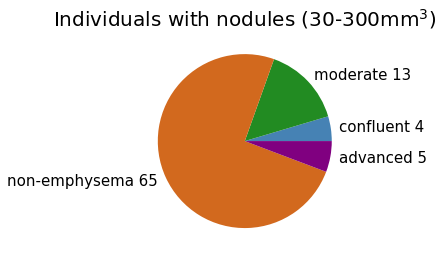

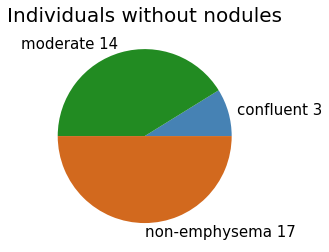

In [144]:
#Pie chart of number of participants with/without nodules in each of the emphysema/non-emphysema groups
colors_new=['steelblue','forestgreen','chocolate','purple']

y = np.array([len(np.unique(patient_confluent_100_names+patient_confluent_100_300_names)),
              len(np.unique(patient_moderate_100_names+patient_moderate_100_300_names)),len(np.unique(all_pats)),
              #all_pats those without emphysema and with nodules >30 and <300mm3
              len(np.unique(patient_advanced_100_names+patient_advanced_100_300_names))])

mylabels = ['confluent '+str(len(np.unique(patient_confluent_100_names+patient_confluent_100_300_names))),
            'moderate '+str(len(np.unique(patient_moderate_100_names+patient_moderate_100_300_names))),
            'non-emphysema '+str(len(np.unique(all_pats))), 
            "advanced "+str(len(np.unique(patient_advanced_100_names+patient_advanced_100_300_names)))]

plt.pie(y, labels = mylabels,colors=colors_new, textprops={'fontsize': 15})
plt.title('Individuals with nodules (30-300mm$^3$)', fontsize=20)
plt.show() 


y = np.array([3,14,17])
mylabels = ['confluent '+str(y[0]),'moderate '+str(y[1]),'non-emphysema '+str(y[2])] #All advanced patients have nodules

plt.pie(y, labels = mylabels,colors=colors_new, textprops={'fontsize': 15})
plt.title('Individuals without nodules', fontsize=20)
plt.show() 

In [67]:
# occurrences = collections.Counter(all_pats) #Count how many times a participant is chosen (=num of nodules matched from it)
# print(occurrences)

In [147]:
# emphysema_data[emphysema_data['volume_all_n1']==657] #Check for where volume match below not found - 657,28553,289,295
# sizes_confluent_300 #non-empty with values 657, 28553 for which initial matches with d=100 did not exist

In [68]:
#If we need to check volumes on RedCap and compare with volumes of AI for non-emphysema cases (manually for now)
non_emphysema_pats=emphysema_data[emphysema_data['participant_id'].isin(np.unique(all_pats))].iloc[:,[0,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1]].sort_values('participant_id')
non_emphysema_pats

#### Manually check volumes of nodules to see if subsolid component can be matched

In [69]:
check_noemph=emphysema_data[emphysema_data['participant_id'].isin(np.unique(all_pats))]
cols_check=[col for col in emphysema_data.columns if 'volume_al' in col or 'participant_id' in col]
df_check=check_noemph[cols_check]

#Below are teh volumes of the 3 findings in the emphysema group with a subsolid component that could not be matched in the non-emphysema group
selected_rows = df_check[(df_check >= 65) & (df_check <= 85)].dropna(how='all') #388787 n2 can be matched to this (but not correct)
# selected_rows = df_check[(df_check >= 115) & (df_check <= 135)].dropna(how='all') #662368 n1 can be matched to this (but not correct)
# selected_rows = df_check[(df_check >= 319) & (df_check <= 339)].dropna(how='all') #no match possible!

selected_rows['participant_id']=df_check['participant_id']
selected_rows

In [150]:
##For debug
# cols_check=[col for col in emphysema_data.columns if 'volume_sub' in col or 'participant_id' in col]
# df_check=check_noemph[cols_check]
# df_check[df_check['participant_id']==388787] 
# df_check[df_check['participant_id']==662368] 

In [151]:
#Volumes of nodules of non-emphysema list - Similar as above without participant_id to be used below
only_vols=emphysema_data[emphysema_data['participant_id'].isin(np.unique(all_pats))].iloc[:,[-10,-9,-8,-7,-6,-5,-4,-3,-2,-1]]

#Get number of nodules of participants in the non-emphysema list
new_vols=[]
for col in only_vols.columns:
    new_vols.append(only_vols[col]) 

new_vols=[i for x in new_vols for i in x]
new_vols=[x for x in new_vols if np.isnan(x)==False]

print("Total num of nodules in non-emphysema list is {}".format(len(new_vols)))
# np.sum(only_vols.count()) #another way to get their number

Total num of nodules in non-emphysema list is 143


In [152]:
new_vols_100=[x for x in new_vols if x<=100] #If we want only nodules <=100mm3
new_vols_100_300=[x for x in new_vols if x<=300 and x>100] #If we want only nodules 100<x<=300mm3
new_vols_300=[x for x in new_vols if x>300] #If we want only nodules >300mm3
print("Total num of nodules in non-emphysema list of size 30-100mm3 is {}".format(len(new_vols_100)))
print("Total num of nodules in non-emphysema list of size 100-300mm3 is {}".format(len(new_vols_100_300)))
print("Total num of nodules in non-emphysema list of size >300mm3 is {}".format(len(new_vols_300)))
#We expect to have nodules >300mm3 here, even though not explicitly sampled, since we sample on a scan basis.

Total num of nodules in non-emphysema list of size 30-100mm3 is 107
Total num of nodules in non-emphysema list of size 100-300mm3 is 24
Total num of nodules in non-emphysema list of size >300mm3 is 12


In [153]:
adv_vols_100=[x for x in sizes_advanced if x<=100] #If we want only nodules <=100mm3
adv_vols_100_300=[x for x in sizes_advanced if x<=300 and x>100] #If we want only nodules 100<x<=300mm3
print("Total num of nodules in advanced list is {}".format(len(sizes_advanced)))
print("Total num of nodules in advanced list of size 30-100mm3 is {}".format(len(adv_vols_100)))
print("Total num of nodules in advanced list of size 100-300mm3 is {}".format(len(adv_vols_100_300)))
print('\n')

conf_vols_100=[x for x in sizes_confluent if x<=100] #If we want only nodules <=100mm3
conf_vols_100_300=[x for x in sizes_confluent if x<=300 and x>100] #If we want only nodules 100<x<=300mm3
print("Total num of nodules in confluent list is {}".format(len(sizes_confluent)))
print("Total num of nodules in confluent list of size 30-100mm3 is {}".format(len(conf_vols_100)))
print("Total num of nodules in confluent list of size 100-300mm3 is {}".format(len(conf_vols_100_300)))
print('\n')

mod_vols_100=[x for x in sizes_moderate if x<=100] #If we want only nodules <=100mm3
mod_vols_100_300=[x for x in sizes_moderate if x<=300 and x>100] #If we want only nodules 100<x<=300mm3
print("Total num of nodules in moderate list is {}".format(len(sizes_moderate)))
print("Total num of nodules in moderate list of size 30-100mm3 is {}".format(len(mod_vols_100)))
print("Total num of nodules in moderate list of size 100-300mm3 is {}".format(len(mod_vols_100_300)))

Total num of nodules in advanced list is 24
Total num of nodules in advanced list of size 30-100mm3 is 15
Total num of nodules in advanced list of size 100-300mm3 is 9


Total num of nodules in confluent list is 8
Total num of nodules in confluent list of size 30-100mm3 is 6
Total num of nodules in confluent list of size 100-300mm3 is 0


Total num of nodules in moderate list is 46
Total num of nodules in moderate list of size 30-100mm3 is 35
Total num of nodules in moderate list of size 100-300mm3 is 10


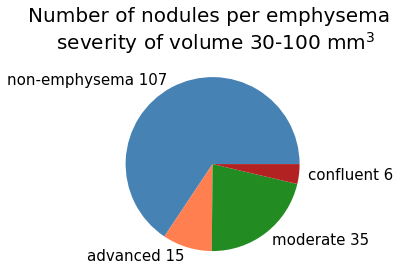

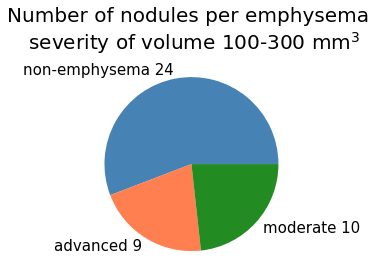

In [154]:
#Compare total number of nodules for each volume subgroup (emphysema/non-emphysema)

colors = ['steelblue','coral','forestgreen','firebrick']

#30-100mm3
y = np.array([len(new_vols_100),len(adv_vols_100),len(mod_vols_100),len(conf_vols_100)])
mylabels = [ "non-emphysema "+str(len(new_vols_100)), "advanced "+str(len(adv_vols_100)),
            "moderate "+str(len(mod_vols_100)),"confluent "+str(len(conf_vols_100))]

plt.pie(y, labels = mylabels,colors=colors, textprops={'fontsize': 15})
plt.title('Number of nodules per emphysema \n severity of volume 30-100 mm$^3$', fontsize=20)
plt.show() 

#100-300mm3
y = np.array([len(new_vols_100_300),len(adv_vols_100_300),len(mod_vols_100_300)]) #no confluent nodules in this subgroup
mylabels = [ "non-emphysema "+str(len(new_vols_100_300)), "advanced "+str(len(adv_vols_100_300)),
            "moderate "+str(len(mod_vols_100_300))] 

plt.pie(y, labels = mylabels,colors=colors, textprops={'fontsize': 15})
plt.title('Number of nodules per emphysema \n severity of volume 100-300 mm$^3$', fontsize=20)
plt.show() 

In [155]:
severe_emph_sizes=[] #Combine all sizes of all nodules in emphysema group to one list
severe_emph_sizes.extend(sizes_advanced)
severe_emph_sizes.extend(sizes_confluent)
severe_emph_sizes.extend(sizes_moderate)

for emph_type in new_severity_names[:-1]: #Loop over emphysema types, ignoring non-emphysema
    for big_size in eval("sizes_"+emph_type+"_300"):
        severe_emph_sizes.remove(big_size)
    
print("Total number of nods in adv+mod+conf emphysema group is {} (without considering nodules >300mm3 - no matching exists)"
      .format(len(severe_emph_sizes)))

Total number of nods in adv+mod+conf emphysema group is 75 (without considering nodules >300mm3 - no matching exists)


In [156]:
new_vols_small=[x for x in new_vols if x<=300] #If we want only nodules <300mm3 for the non-emphysema cases
print("Total number of nods in non-emphysema group (30-300mm3) is",len(new_vols_small))

Total number of nods in non-emphysema group (30-300mm3) is 131


In [157]:
# sns.histplot(new_vols) #Plot all the resampled volumes from non-emphysema cases - Bad graph due to outliers

Text(0.5, 0, 'Nodule Size ($mm^3$)')

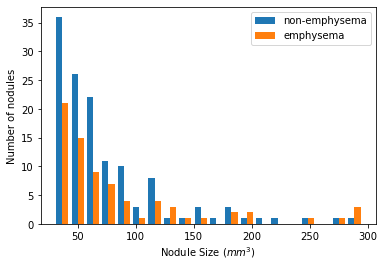

In [158]:
plt.hist([new_vols_small,severe_emph_sizes],bins=20)
plt.legend(['non-emphysema','emphysema']) #(>30 $mm^3$ and <300 $mm^3$)
plt.ylabel('Number of nodules')
plt.xlabel('Nodule Size ($mm^3$)')
# plt.savefig("nodule_distribution.png")

# If larger distance, edge on right because of that greater distance for resampling d=1300 (~36) instead of 100 (10)

In [159]:
print("Emphysema group median size:",np.median(severe_emph_sizes),"IQR:",st.iqr(severe_emph_sizes))
print("Non-emphysema group median size:",np.median(new_vols_small),"IQR:",st.iqr(new_vols_small))

res = st.median_test(severe_emph_sizes, new_vols_small)
print("P value is {}".format(res[1])) #this is pvalue

Emphysema group median size: 58.0 IQR: 56.5
Non-emphysema group median size: 59.0 IQR: 43.5
P value is 0.9372387638938695


In [160]:
# #Get distribution for new samples with their parameters
# def distribution_fit(samples,size='_100'):
#     params,dist_results=get_best_distribution(samples) #Fit a distribution to the new samples and get its params
#     new_name=[]
#     new_value=[]

#     for name, value in dist_results:
#         if np.isnan(float(value))==False:
#             new_name.append(name)
#             new_value.append(float(value))

#     new_value_fin,new_name_fin=zip(*sorted(zip(new_value,new_name)))

#     print("Distributions for size {} are {} with p values {}".format(size,new_name_fin[-5:],new_value_fin[-5:]))

In [161]:
# severe_emph_sizes_100=[x for x in severe_emph_sizes if x<=100]
# severe_emph_sizes_100_300=[x for x in severe_emph_sizes if x>100 and x<=300]

# distribution_fit(severe_emph_sizes_100)
# distribution_fit(severe_emph_sizes_100_300,size='100_300')

In [162]:
# distribution_fit(new_vols_100)
# distribution_fit(new_vols_100_300,size='100_300')

In [163]:
#100-300mm3 volumes only ~ 20 elements each - difficult to have similar distribution
#0-100mm3 more similar (55 and 104 elements)

In [164]:
end=time.time()
print("Time to execute the script is {} sec".format(end-start)) #~7mins with statistics, ~30secs without

Time to execute the script is 10.464321613311768 sec
